# 자전거 대여 데이터 분석 개인 프로젝트
- 새싹 도봉캠퍼스 김현서

### 0. 라이브러리

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.metrics import r2_score, root_mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier, RandomForestRegressor

### 1. 데이터 확인

In [2]:
# 데이터 읽어오기

df = pd.read_csv('./data/bike.csv')

In [ ]:
df = pd.read_csv('./data/bike.csv')
df.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1

In [4]:
# 편의를 위해 column name 수정

df = df.rename(columns={
    'datetime': '일시',
    'season': '계절',
    'holiday': '휴일여부',  # 휴일이 아닌 경우 0
    'workingday': '주말주중',  # 주말이 0이고 주중이 1이므로 앞뒤로 배치
    'weather': '날씨',  # 맑음, 약간 구름 낀 흐림: 1, 안개, 안개+흐림: 2, 가벼운 눈, 비+천둥: 3, 심한 눈, 비, 천둥, 번개: 4
    'temp': '온도',  # 섭씨
    'atemp': '체감온도',  # 섭씨
    'humidity': '상대습도',
    'windspeed': '풍속',
    'casual': '미등록대여횟수',
    'registered': '등록대여횟수',
    'count': '대여횟수'
})

df.head()

일시  계절  휴일여부  주말주중  날씨    온도    체감온도  상대습도   풍속  미등록대여횟수  \
0  2011-01-01 00:00:00   1     0     0   1  9.84  14.395    81  0.0        3   
1  2011-01-01 01:00:00   1     0     0   1  9.02  13.635    80  0.0        8   
2  2011-01-01 02:00:00   1     0     0   1  9.02  13.635    80  0.0        5   
3  2011-01-01 03:00:00   1     0     0   1  9.84  14.395    75  0.0        3   
4  2011-01-01 04:00:00   1     0     0   1  9.84  14.395    75  0.0        0   

   등록대여횟수  대여횟수  
0      13    16  
1      32    40  
2      27    32  
3      10    13  
4       1     1

In [5]:
# 데이터 기본 정보 출력

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   일시       10886 non-null  object 
 1   계절       10886 non-null  int64  
 2   휴일여부     10886 non-null  int64  
 3   주말주중     10886 non-null  int64  
 4   날씨       10886 non-null  int64  
 5   온도       10886 non-null  float64
 6   체감온도     10886 non-null  float64
 7   상대습도     10886 non-null  int64  
 8   풍속       10886 non-null  float64
 9   미등록대여횟수  10886 non-null  int64  
 10  등록대여횟수   10886 non-null  int64  
 11  대여횟수     10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


- 10886개의 row
- 12개의 column
- 결측치 없음을 확인
- 일시가 datetime type이 아닌 object type

In [6]:
# 일시 column의 type을 datetime으로 변경

df['일시'] = pd.to_datetime(df['일시'], format='%Y-%m-%d %H:%M:%S')

df['일시'].head()

0   2011-01-01 00:00:00
1   2011-01-01 01:00:00
2   2011-01-01 02:00:00
3   2011-01-01 03:00:00
4   2011-01-01 04:00:00
Name: 일시, dtype: datetime64[ns]

In [7]:
# 일시 column에 중복된 행이 있는지 확인

df['일시'].duplicated().sum()

np.int64(0)

In [8]:
# 데잍 기초 통계 정보 출력

df.describe()

일시            계절          휴일여부  \
count                          10886  10886.000000  10886.000000   
mean   2011-12-27 05:56:22.399411968      2.506614      0.028569   
min              2011-01-01 00:00:00      1.000000      0.000000   
25%              2011-07-02 07:15:00      2.000000      0.000000   
50%              2012-01-01 20:30:00      3.000000      0.000000   
75%              2012-07-01 12:45:00      4.000000      0.000000   
max              2012-12-19 23:00:00      4.000000      1.000000   
std                              NaN      1.116174      0.166599   

               주말주중            날씨           온도          체감온도          상대습도  \
count  10886.000000  10886.000000  10886.00000  10886.000000  10886.000000   
mean       0.680875      1.418427     20.23086     23.655084     61.886460   
min        0.000000      1.000000      0.82000      0.760000      0.000000   
25%        0.000000      1.000000     13.94000     16.665000     47.000000   
50%        1.000000      1.000000     20.50000     24.240000     62.000000   
75%        1.000000      2.000000     26.24000     31.060000     77.000000   
max        1.000000      4.000000     41.00000     45.455000    100.000000   
std        0.466159      0.633839      7.79159      8.474601     19.245033   

                 풍속       미등록대여횟수        등록대여횟수          대여횟수  
count  10886.000000  10886.000000  10886.000000  10886.000000  
mean      12.799395     36.021955    155.552177    191.574132  
min        0.000000      0.000000      0.000000      1.000000  
25%        7.001500      4.000000     36.000000     42.000000  
50%       12.998000     17.000000    118.000000    145.000000  
75%       16.997900     49.000000    222.000000    284.000000  
max       56.996900    367.000000    886.000000    977.000000  
std        8.164537     49.960477    151.039033    181.144454

일시
- 2011년부터 2012년까지의 데이터를 보유


- 다양한 시간적인 특성을 활용하기 위해 연, 월, 일, 시간로 나누어서 새로운 컬럼을 생성하는 것은?
- 한 시간 단위로 기록되어 있기 때문에 분, 초는 생략한다
- 다른 방법으로 시간 데이터를 나누는 것이 더 효과적일 수 있으므로, 데이터프레임을 카피해서 생성한다

In [9]:
# 일시 컬럼을 나눠서 사용할 데이터프레임 카피본

df_time = df.copy()

df_time.head()

일시  계절  휴일여부  주말주중  날씨    온도    체감온도  상대습도   풍속  미등록대여횟수  \
0 2011-01-01 00:00:00   1     0     0   1  9.84  14.395    81  0.0        3   
1 2011-01-01 01:00:00   1     0     0   1  9.02  13.635    80  0.0        8   
2 2011-01-01 02:00:00   1     0     0   1  9.02  13.635    80  0.0        5   
3 2011-01-01 03:00:00   1     0     0   1  9.84  14.395    75  0.0        3   
4 2011-01-01 04:00:00   1     0     0   1  9.84  14.395    75  0.0        0   

   등록대여횟수  대여횟수  
0      13    16  
1      32    40  
2      27    32  
3      10    13  
4       1     1

In [ ]:
# 새로운 시간 단위 컬럼들 생성

df_time['연도'] = df_time['일시'].dt.year
df_time['월'] = df_time['일시'].dt.month
df_time['일'] = df_time['일시'].dt.day
df_time['시간'] = df_time['일시'].dt.hour

In [82]:
df_time[['연도', '월', '일', '시간']].head()

연도  월  일  시간
0  2011  1  1   0
1  2011  1  1   1
2  2011  1  1   2
3  2011  1  1   3
4  2011  1  1   4

In [11]:
# 일시 컬럼 제거

df_time = df_time.drop('일시', axis=1)

df_time.head()

계절  휴일여부  주말주중  날씨    온도    체감온도  상대습도   풍속  미등록대여횟수  등록대여횟수  대여횟수    연도  \
0   1     0     0   1  9.84  14.395    81  0.0        3      13    16  2011   
1   1     0     0   1  9.02  13.635    80  0.0        8      32    40  2011   
2   1     0     0   1  9.02  13.635    80  0.0        5      27    32  2011   
3   1     0     0   1  9.84  14.395    75  0.0        3      10    13  2011   
4   1     0     0   1  9.84  14.395    75  0.0        0       1     1  2011   

   월  일  시간  
0  1  1   0  
1  1  1   1  
2  1  1   2  
3  1  1   3  
4  1  1   4

In [12]:
# 다시 통계 자료 추출

df_time.describe()

계절          휴일여부          주말주중            날씨           온도  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.00000   
mean       2.506614      0.028569      0.680875      1.418427     20.23086   
std        1.116174      0.166599      0.466159      0.633839      7.79159   
min        1.000000      0.000000      0.000000      1.000000      0.82000   
25%        2.000000      0.000000      0.000000      1.000000     13.94000   
50%        3.000000      0.000000      1.000000      1.000000     20.50000   
75%        4.000000      0.000000      1.000000      2.000000     26.24000   
max        4.000000      1.000000      1.000000      4.000000     41.00000   

               체감온도          상대습도            풍속       미등록대여횟수        등록대여횟수  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      23.655084     61.886460     12.799395     36.021955    155.552177   
std        8.474601     19.245033      8.164537     49.960477    151.039033   
min        0.760000      0.000000      0.000000      0.000000      0.000000   
25%       16.665000     47.000000      7.001500      4.000000     36.000000   
50%       24.240000     62.000000     12.998000     17.000000    118.000000   
75%       31.060000     77.000000     16.997900     49.000000    222.000000   
max       45.455000    100.000000     56.996900    367.000000    886.000000   

               대여횟수            연도             월             일            시간  
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000  
mean     191.574132   2011.501929      6.521495      9.992559     11.541613  
std      181.144454      0.500019      3.444373      5.476608      6.915838  
min        1.000000   2011.000000      1.000000      1.000000      0.000000  
25%       42.000000   2011.000000      4.000000      5.000000      6.000000  
50%      145.000000   2012.000000      7.000000     10.000000     12.000000  
75%      284.000000   2012.000000     10.000000     15.000000     18.000000  
max      977.000000   2012.000000     12.000000     19.000000     23.000000

명목 데이터
- 계절, 날씨, 휴일여부, 주말주중


수치 데이터
- 온도, 체감온도, 상대습도, 풍속, 연도, 월, 일, 미등록대여횟수, 등록대여횟수, 대여횟수

### 2. 데이터 전처리

In [13]:
# info에서 확인했지만 한 번 더 결측치 확인

df_time.isnull().sum()

계절         0
휴일여부       0
주말주중       0
날씨         0
온도         0
체감온도       0
상대습도       0
풍속         0
미등록대여횟수    0
등록대여횟수     0
대여횟수       0
연도         0
월          0
일          0
시간         0
dtype: int64

In [14]:
# 그래프에 한글 적용

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

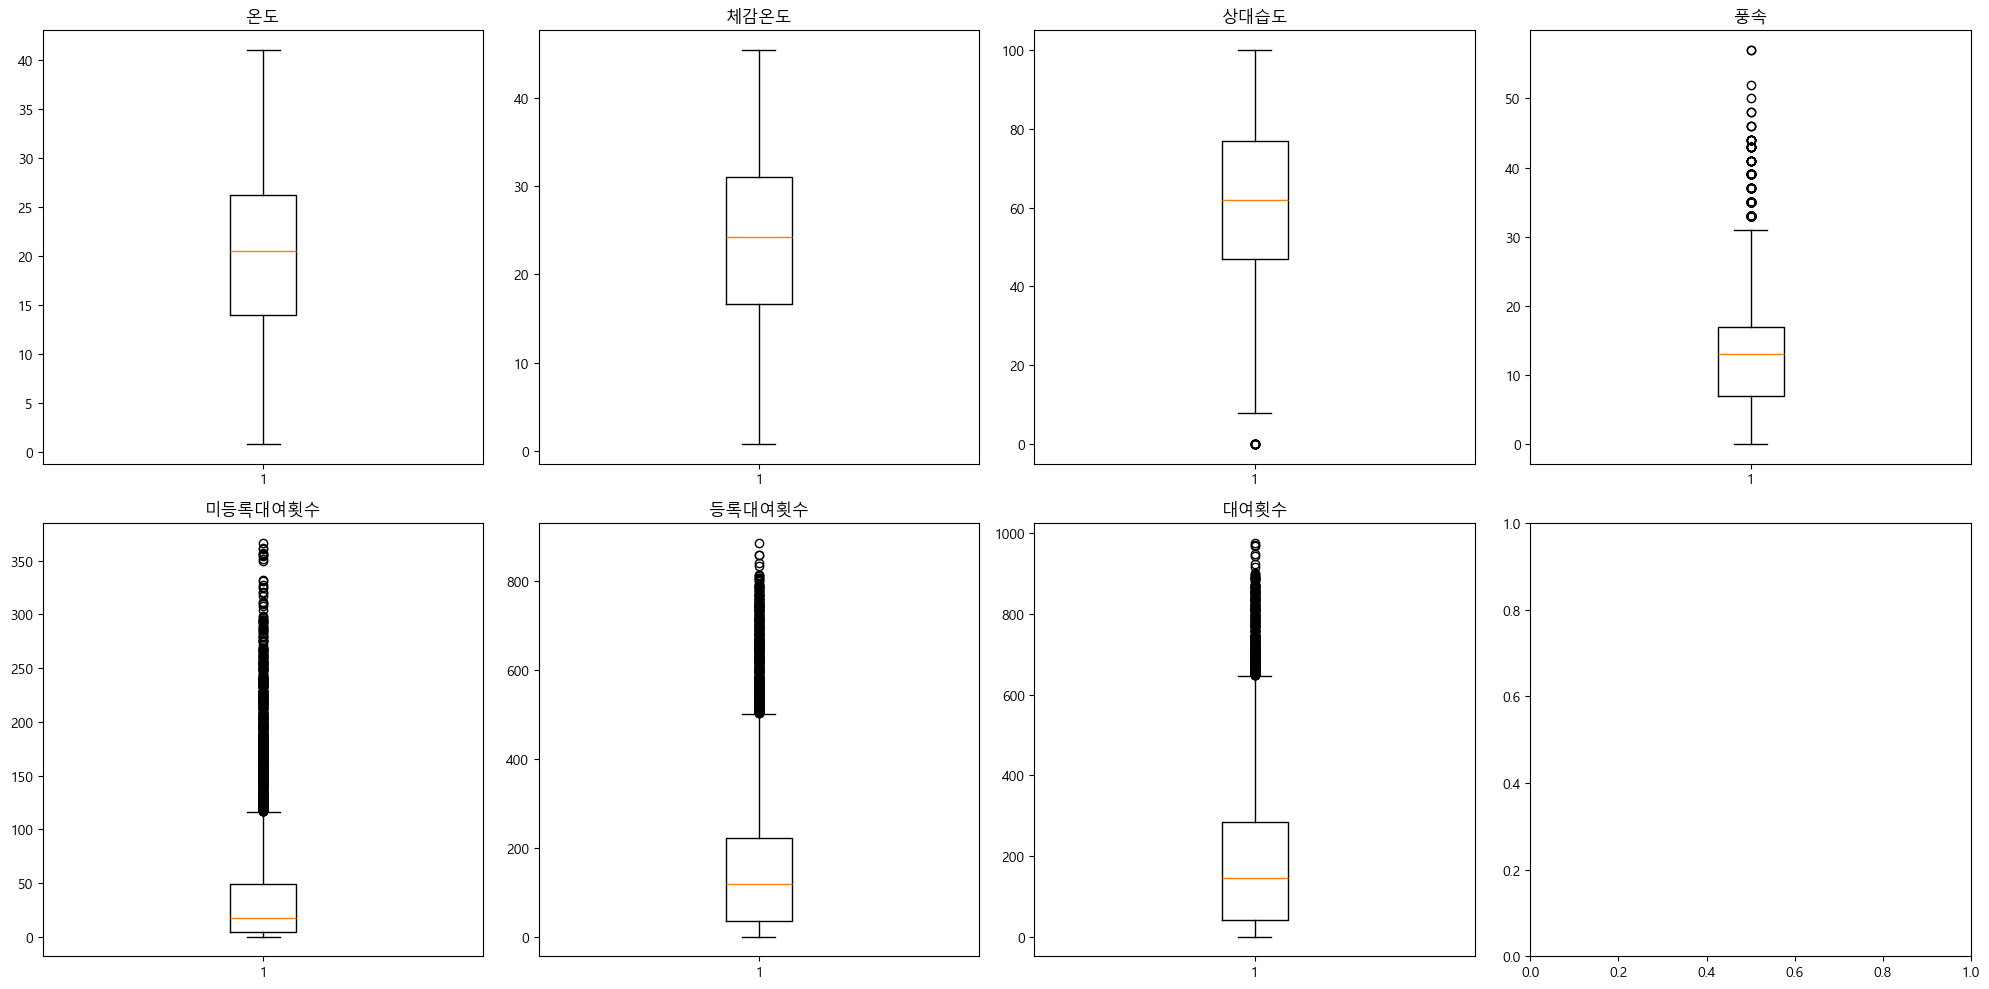

In [84]:
# 이상치가 있는지 박스 플롯을 통해 확인

numeric_features = ['온도', '체감온도', '상대습도', '풍속', '미등록대여횟수', '등록대여횟수', '대여횟수']

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i, feature in enumerate(numeric_features):
    ax = axs[i//4, i%4]
    ax.boxplot(df_time[feature])
    ax.set_title(f'{feature}')

plt.tight_layout()
plt.show()

- 이런 또로로록 이상치도 제거해야하나?

In [16]:
# 이상치 제거 버전, row 427개 제거됨

df_out = df_time.copy()
df_out = df_out[df_out['풍속'] <= 30]
df_out

계절  휴일여부  주말주중  날씨     온도    체감온도  상대습도       풍속  미등록대여횟수  등록대여횟수  \
0       1     0     0   1   9.84  14.395    81   0.0000        3      13   
1       1     0     0   1   9.02  13.635    80   0.0000        8      32   
2       1     0     0   1   9.02  13.635    80   0.0000        5      27   
3       1     0     0   1   9.84  14.395    75   0.0000        3      10   
4       1     0     0   1   9.84  14.395    75   0.0000        0       1   
...    ..   ...   ...  ..    ...     ...   ...      ...      ...     ...   
10881   4     0     1   1  15.58  19.695    50  26.0027        7     329   
10882   4     0     1   1  14.76  17.425    57  15.0013       10     231   
10883   4     0     1   1  13.94  15.910    61  15.0013        4     164   
10884   4     0     1   1  13.94  17.425    61   6.0032       12     117   
10885   4     0     1   1  13.12  16.665    66   8.9981        4      84   

       대여횟수    연도   월   일  시간  
0        16  2011   1   1   0  
1        40  2011   1   1   1  
2        32  2011   1   1   2  
3        13  2011   1   1   3  
4         1  2011   1   1   4  
...     ...   ...  ..  ..  ..  
10881   336  2012  12  19  19  
10882   241  2012  12  19  20  
10883   168  2012  12  19  21  
10884   129  2012  12  19  22  
10885    88  2012  12  19  23  

[10459 rows x 15 columns]

어떤 분석이 가능할까?
- 대여 횟수를 종속 변수로 하는 선형 회귀 분석
- 미등록대여가 많은 경우를 0, 등록대여가 많은 경우를 1로 치환하여 분류 분석
- 대여 유형 확인을 위한 군집화 분석

### 4. 선형 회귀 분석

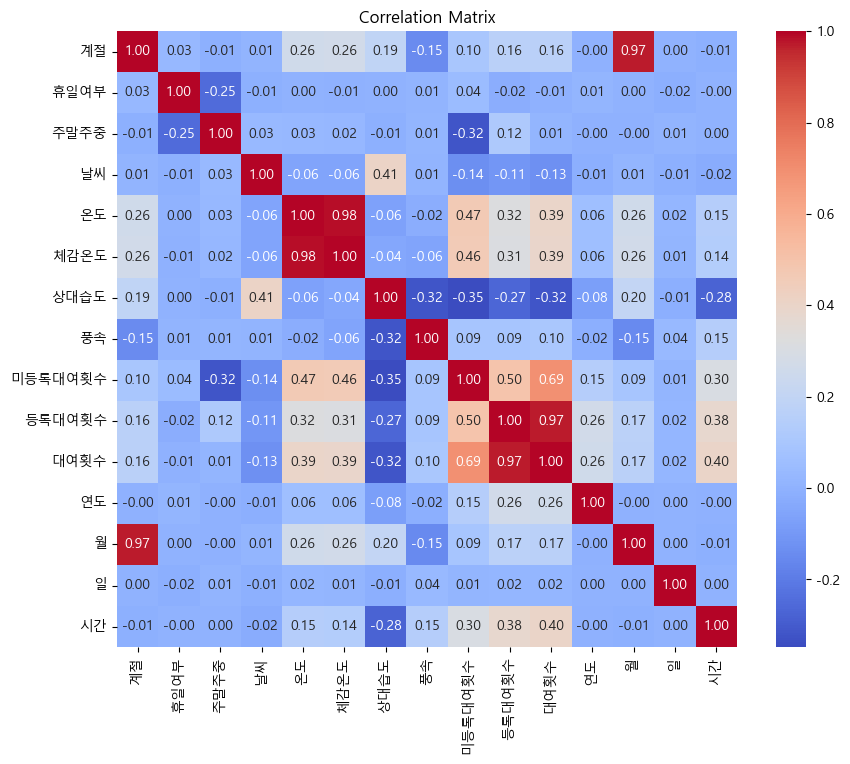

In [17]:
# 상관관계 확인

plt.figure(figsize=(10, 8))
sns.heatmap(df_time.corr(), cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [18]:
sorted_corr = df_time.corr().abs().unstack().sort_values(ascending=False)
sorted_corr = sorted_corr[(sorted_corr != 1) & (sorted_corr >= 0.9)]  # 일반적으로 0.9 이상의 상관계수가 강한 상관관계라고 판단되기 때문에

print(sorted_corr)

체감온도    온도        0.984948
온도      체감온도      0.984948
계절      월         0.971524
월       계절        0.971524
대여횟수    등록대여횟수    0.970948
등록대여횟수  대여횟수      0.970948
dtype: float64


다중공선성
- 체감온도와 온도가 서로 큰 상관관계를 가지고 있으므로 체감온도 제거 (실제 기온을 나타내는 값을 유지하는 것이 좋을 것이라고 판단, 체감온도는 날씨/습도 등에서 추가적으로 고려할 수 있을 듯)
- 계절과 월이 서로 큰 상관관계를 가지고 있으므로 계절 제거 (월이 더 많은 범위를 포함하고 있다고 생각했기 때문에, 예측해보고 더 성능이 좋은 것을 사용할수도)

In [19]:
df_cor = df_time.drop(['계절', '체감온도'], axis=1)

df_cor.head()

휴일여부  주말주중  날씨    온도  상대습도   풍속  미등록대여횟수  등록대여횟수  대여횟수    연도  월  일  시간
0     0     0   1  9.84    81  0.0        3      13    16  2011  1  1   0
1     0     0   1  9.02    80  0.0        8      32    40  2011  1  1   1
2     0     0   1  9.02    80  0.0        5      27    32  2011  1  1   2
3     0     0   1  9.84    75  0.0        3      10    13  2011  1  1   3
4     0     0   1  9.84    75  0.0        0       1     1  2011  1  1   4

In [20]:
# 모델링

X1 = df_cor.drop('대여횟수', axis=1)
y1 = df_cor['대여횟수']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

lr1 = LinearRegression()
lr1.fit(X1_train, y1_train)

LinearRegression()

In [21]:
# 예측

y1_pred = lr1.predict(X1_test)
print(f'기울기: {lr1.coef_}')

기울기: [-1.87837901e-15  1.01696429e-13 -2.98569763e-14 -1.40599338e-15
  6.59628602e-16  1.25073563e-15  1.00000000e+00  1.00000000e+00
  7.70087119e-15  9.39833877e-16  1.99493200e-16  2.40519410e-15]


In [22]:
# 실제 데이터와 비교

result1 = pd.DataFrame({
    '실제 데이터': y1_test,
    '예측 데이터': y1_pred
})

result1[40:50]

실제 데이터  예측 데이터
5817     132   132.0
8257     186   186.0
5380       3     3.0
7078     296   296.0
1084     194   194.0
6742       6     6.0
5638       5     5.0
9395     404   404.0
1576     145   145.0
346       26    26.0

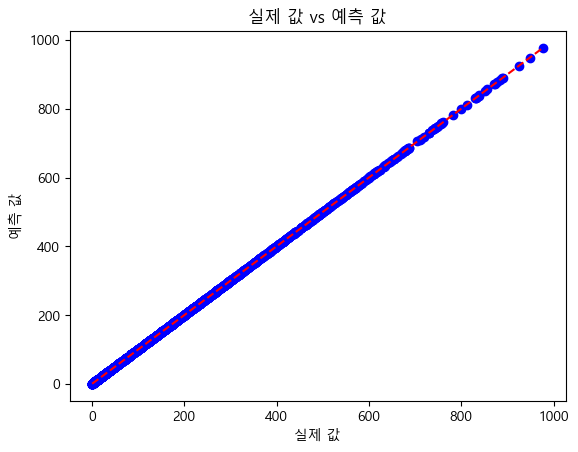

In [23]:
plt.scatter(y1_test, y1_pred, c='b')
plt.plot([min(y1_test), max(y1_test)], [min(y1_test), max(y1_test)], 'r--')  # y = x 직선
plt.xlabel('실제 값')
plt.ylabel('예측 값')
plt.title('실제 값 vs 예측 값')
plt.show()

In [24]:
r21 = r2_score(y1_test, y1_pred)  # 1과 가까울수록 좋은 모델
rmse1 = root_mean_squared_error(y1_test, y1_pred)  # 값이 작을수록 예측이 잘 된 모델

print(f'r2: {r21}, rmse: {rmse1}')

r2: 1.0, rmse: 1.3097359483989293e-13


+) 왜이렇게잘나와.. 등록, 미등록대여횟수 빼고 진행 > 왜냐면 어차피 대여횟수를 예측하려면 그 값도 없을거니까..

정리: 날씨 데이터와 시간 데이터를 통해 대여횟수를 추측

In [25]:
df_2 = df_cor.drop(['미등록대여횟수', '등록대여횟수'], axis=1)

df_2.head()

휴일여부  주말주중  날씨    온도  상대습도   풍속  대여횟수    연도  월  일  시간
0     0     0   1  9.84    81  0.0    16  2011  1  1   0
1     0     0   1  9.02    80  0.0    40  2011  1  1   1
2     0     0   1  9.02    80  0.0    32  2011  1  1   2
3     0     0   1  9.84    75  0.0    13  2011  1  1   3
4     0     0   1  9.84    75  0.0     1  2011  1  1   4

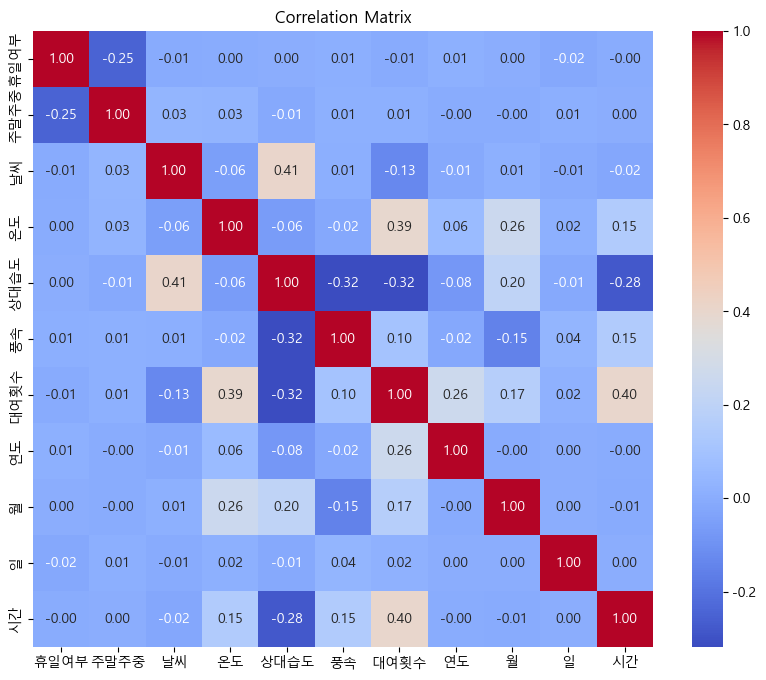

In [26]:
# 상관관계 확인

plt.figure(figsize=(10, 8))
sns.heatmap(df_2.corr(), cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

온도, 습도, 시간

In [27]:
# 모델링

X11 = df_2.drop('대여횟수', axis=1)
y11 = df_2['대여횟수']

X11_train, X11_test, y11_train, y11_test = train_test_split(X11, y11, test_size=0.2, random_state=42)

lr11 = LinearRegression()
lr11.fit(X11_train, y11_train)

LinearRegression()

In [28]:
y11_pred = lr11.predict(X11_test)
print(f'기울기: {lr11.coef_}')

기울기: [-12.06654403   0.23311336  -5.59426865   6.508382    -2.00738343
   0.35879906  82.55369586   7.64606064   0.21617355   7.89506792]


In [86]:
result11 = pd.DataFrame({
    '실제 데이터': y11_test,
    '예측 데이터': y11_pred
})

result11.head()

실제 데이터      예측 데이터
3133     127  242.137704
5786      13   46.454941
5224     163  205.646545
8953     233  289.940583
8054     222  375.695859

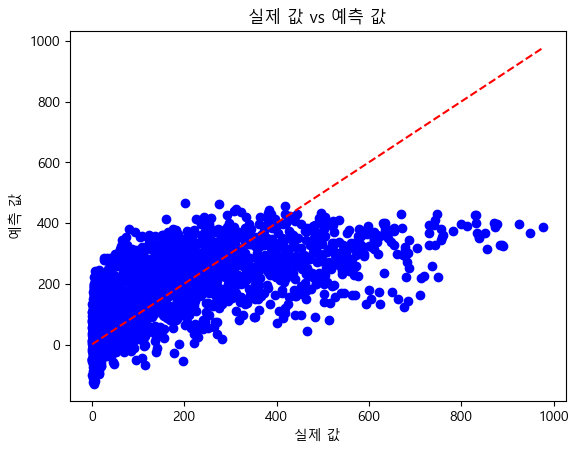

In [30]:
plt.scatter(y11_test, y11_pred, c='b')
plt.plot([min(y11_test), max(y11_test)], [min(y11_test), max(y11_test)], 'r--')  # y = x 직선
plt.xlabel('실제 값')
plt.ylabel('예측 값')
plt.title('실제 값 vs 예측 값')
plt.show()

In [ ]:
r211 = r2_score(y11_test, y11_pred)
rmse11 = root_mean_squared_error(y11_test, y11_pred)

print(f'r2: {r211}, rmse: {rmse11}')

r2: 0.3951319029606065, rmse: 141.2970009794474


Lasso

In [92]:
# X11, y11 그대로 사용

X12_train, X12_test, y12_train, y12_test = train_test_split(X11, y11, test_size=0.2, random_state=42)

ls1 = Lasso(alpha=0.1)
ls1.fit(X12_train, y12_train)

Lasso(alpha=0.1)

In [93]:
y12_pred = ls1.predict(X12_test)
print(f'기울기: {ls1.coef_}')

기울기: [-8.61102974e+00  6.96533412e-02 -5.24666237e+00  6.51082967e+00
 -2.01388656e+00  3.51204447e-01  8.21244649e+01  7.64006463e+00
  2.15192446e-01  7.88914706e+00]


In [89]:
result12 = pd.DataFrame({
    '실제 데이터': y12_test,
    '예측 데이터': y12_pred
})

result12.head()

실제 데이터      예측 데이터
3133     127  242.696455
5786      13   57.163793
5224     163  205.779282
8953     233  289.480065
8054     222  373.344057

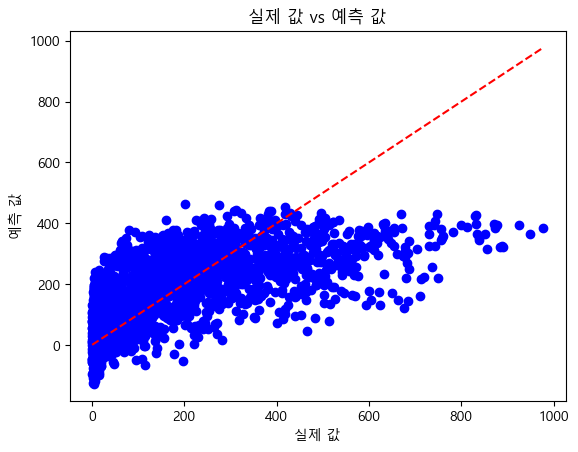

In [90]:
plt.scatter(y12_test, y12_pred, c='b')
plt.plot([min(y12_test), max(y12_test)], [min(y12_test), max(y12_test)], 'r--')  # y = x 직선
plt.xlabel('실제 값')
plt.ylabel('예측 값')
plt.title('실제 값 vs 예측 값')
plt.show()

In [94]:
r212 = r2_score(y12_test, y12_pred)  # 1과 가까울수록 좋은 모델
rmse12 = root_mean_squared_error(y12_test, y12_pred)  # 값이 작을수록 예측이 잘 된 모델

print(f'r2: {r212}, rmse: {rmse12}')

r2: 0.39522833410344094, rmse: 141.28573738788722


Random Forest Regressor

In [37]:
# X11, y11 그대로 사용

Xrr_train, Xrr_test, yrr_train, yrr_test = train_test_split(X11, y11, test_size=0.2, random_state=42)

rfr = RandomForestRegressor(random_state=42, n_estimators=100)
rfr.fit(Xrr_train, yrr_train)

RandomForestRegressor(random_state=42)

In [38]:
yrr_pred = rfr.predict(Xrr_test)

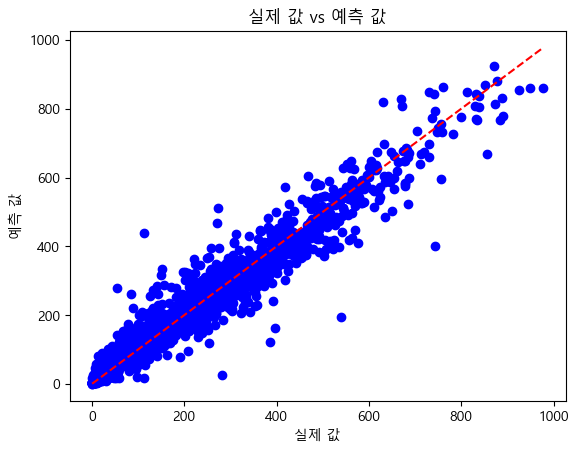

In [39]:
plt.scatter(yrr_test, yrr_pred, c='b')
plt.plot([min(yrr_test), max(yrr_test)], [min(yrr_test), max(yrr_test)], 'r--')  # y = x 직선
plt.xlabel('실제 값')
plt.ylabel('예측 값')
plt.title('실제 값 vs 예측 값')
plt.show()

In [40]:
r2rr = r2_score(yrr_test, yrr_pred)  # 1과 가까울수록 좋은 모델
rmserr = root_mean_squared_error(yrr_test, yrr_pred)  # 값이 작을수록 예측이 잘 된 모델

print(f'r2: {r2rr}, rmse: {rmserr}')

r2: 0.9443686857292535, rmse: 42.851128599165534


randomforest regressor의 성능이 가장 좋다!

K-Fold

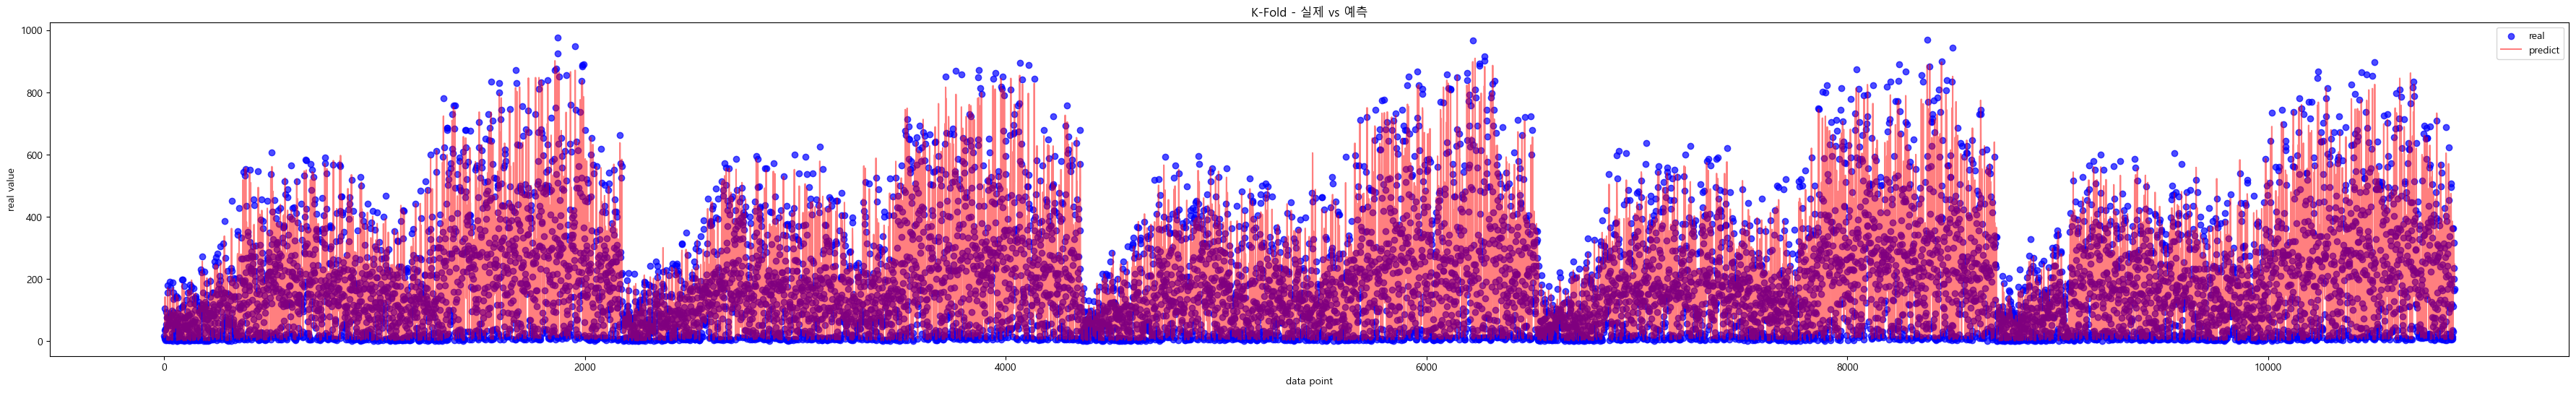

In [41]:
# X11, y11 그대로 사용

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rfrk = RandomForestRegressor(random_state=42, n_estimators=100)

y_test_all = []
y_pred_all = []

for train_index, test_index in kf.split(X11):
	Xrfr_train, Xrfr_test = X11.iloc[train_index], X11.iloc[test_index]
	yrfr_train, yrfr_test = y11.iloc[train_index], y11.iloc[test_index]
	
	rfrk.fit(Xrfr_train, yrfr_train)
	yrfr_pred = rfrk.predict(Xrfr_test)
	
	y_test_all.extend(yrfr_test)
	y_pred_all.extend(yrfr_pred)
	
resultrfr = pd.DataFrame({
	'real': y_test_all,
	'predict': y_pred_all
})

plt.figure(figsize=(45, 6))
plt.scatter(range(len(resultrfr)), resultrfr['real'], color='blue', label='real', alpha=.7)
plt.plot(resultrfr['predict'].values, color='red', label='predict', alpha=.5)
plt.title('K-Fold - 실제 vs 예측')
plt.xlabel('data point')
plt.ylabel('real value')
plt.legend()
plt.show()

In [42]:
r2 = r2_score(y_test_all, y_pred_all)
print(f'결정계수: {r2}')

rmse = root_mean_squared_error(y_test_all, y_pred_all)
print(f'평균 제곱근 오차: {rmse}')  # 3 정도면 나쁘지 않음 

결정계수: 0.9426974676814603
평균 제곱근 오차: 43.36027228131055


KFold 했을 때가 더 낮을수도 있나...?

In [43]:
df_compare = pd.DataFrame({
    '실제 값': yrfr_test,
    '예측 값': yrfr_pred
})

df_compare.head()

실제 값   예측 값
1     40  22.66
4      1   7.04
5      1   8.17
9     14  34.47
11    56  61.41

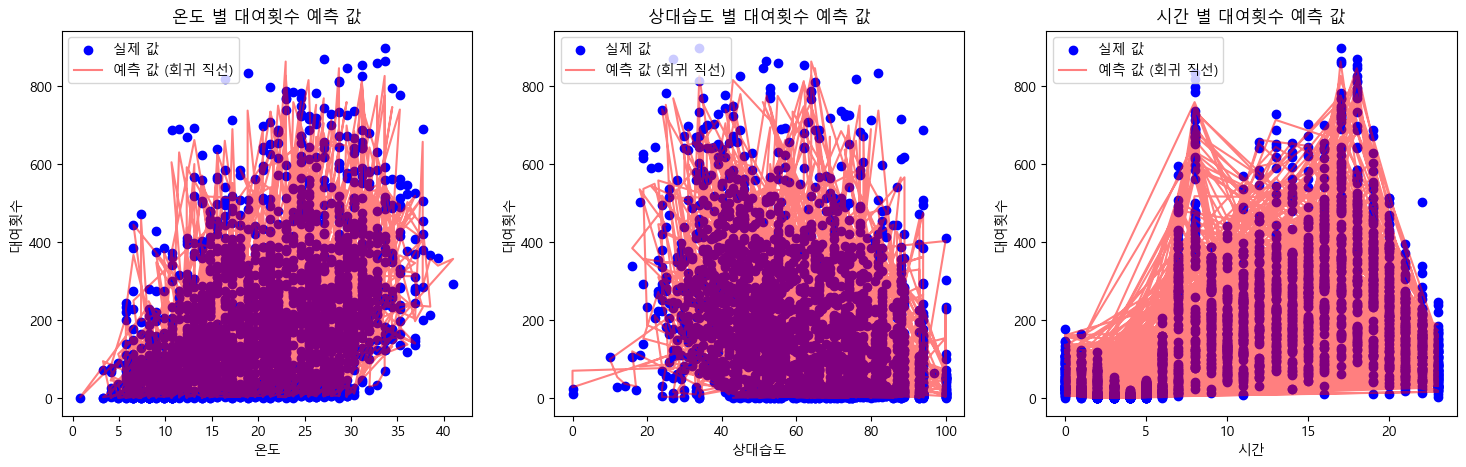

<Figure size 640x480 with 0 Axes>

In [44]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.scatter(Xrfr_test['온도'], yrfr_test, color='blue', label='실제 값')
plt.plot(Xrfr_test['온도'], yrfr_pred, color='red', label='예측 값 (회귀 직선)', alpha=.5)
plt.xlabel('온도')
plt.ylabel('대여횟수')
plt.title('온도 별 대여횟수 예측 값')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(Xrfr_test['상대습도'], yrfr_test, color='blue', label='실제 값')
plt.plot(Xrfr_test['상대습도'], yrfr_pred, color='red', label='예측 값 (회귀 직선)', alpha=.5)
plt.xlabel('상대습도')
plt.ylabel('대여횟수')
plt.title('상대습도 별 대여횟수 예측 값')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(Xrfr_test['시간'], yrfr_test, color='blue', label='실제 값')
plt.plot(Xrfr_test['시간'], yrfr_pred, color='red', label='예측 값 (회귀 직선)', alpha=.5)
plt.xlabel('시간')
plt.ylabel('대여횟수')
plt.title('시간 별 대여횟수 예측 값')
plt.legend()
plt.show()

plt.tight_layout()

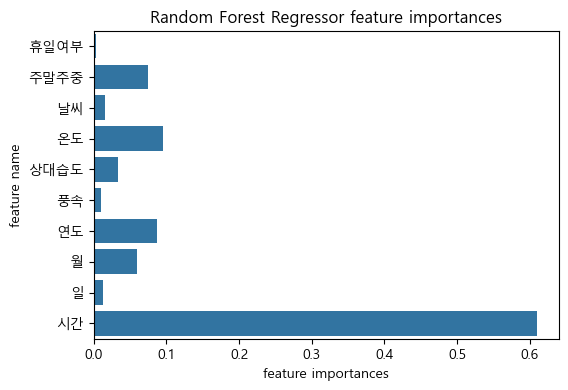

In [45]:
rfr_fi = rfr.feature_importances_

plt.figure(figsize=(6, 4))
sns.barplot(x=rfr_fi, y=Xrfr_test.columns)
plt.title(f'Random Forest Regressor feature importances')
plt.xlabel('feature importances')
plt.ylabel('feature name')
plt.show()

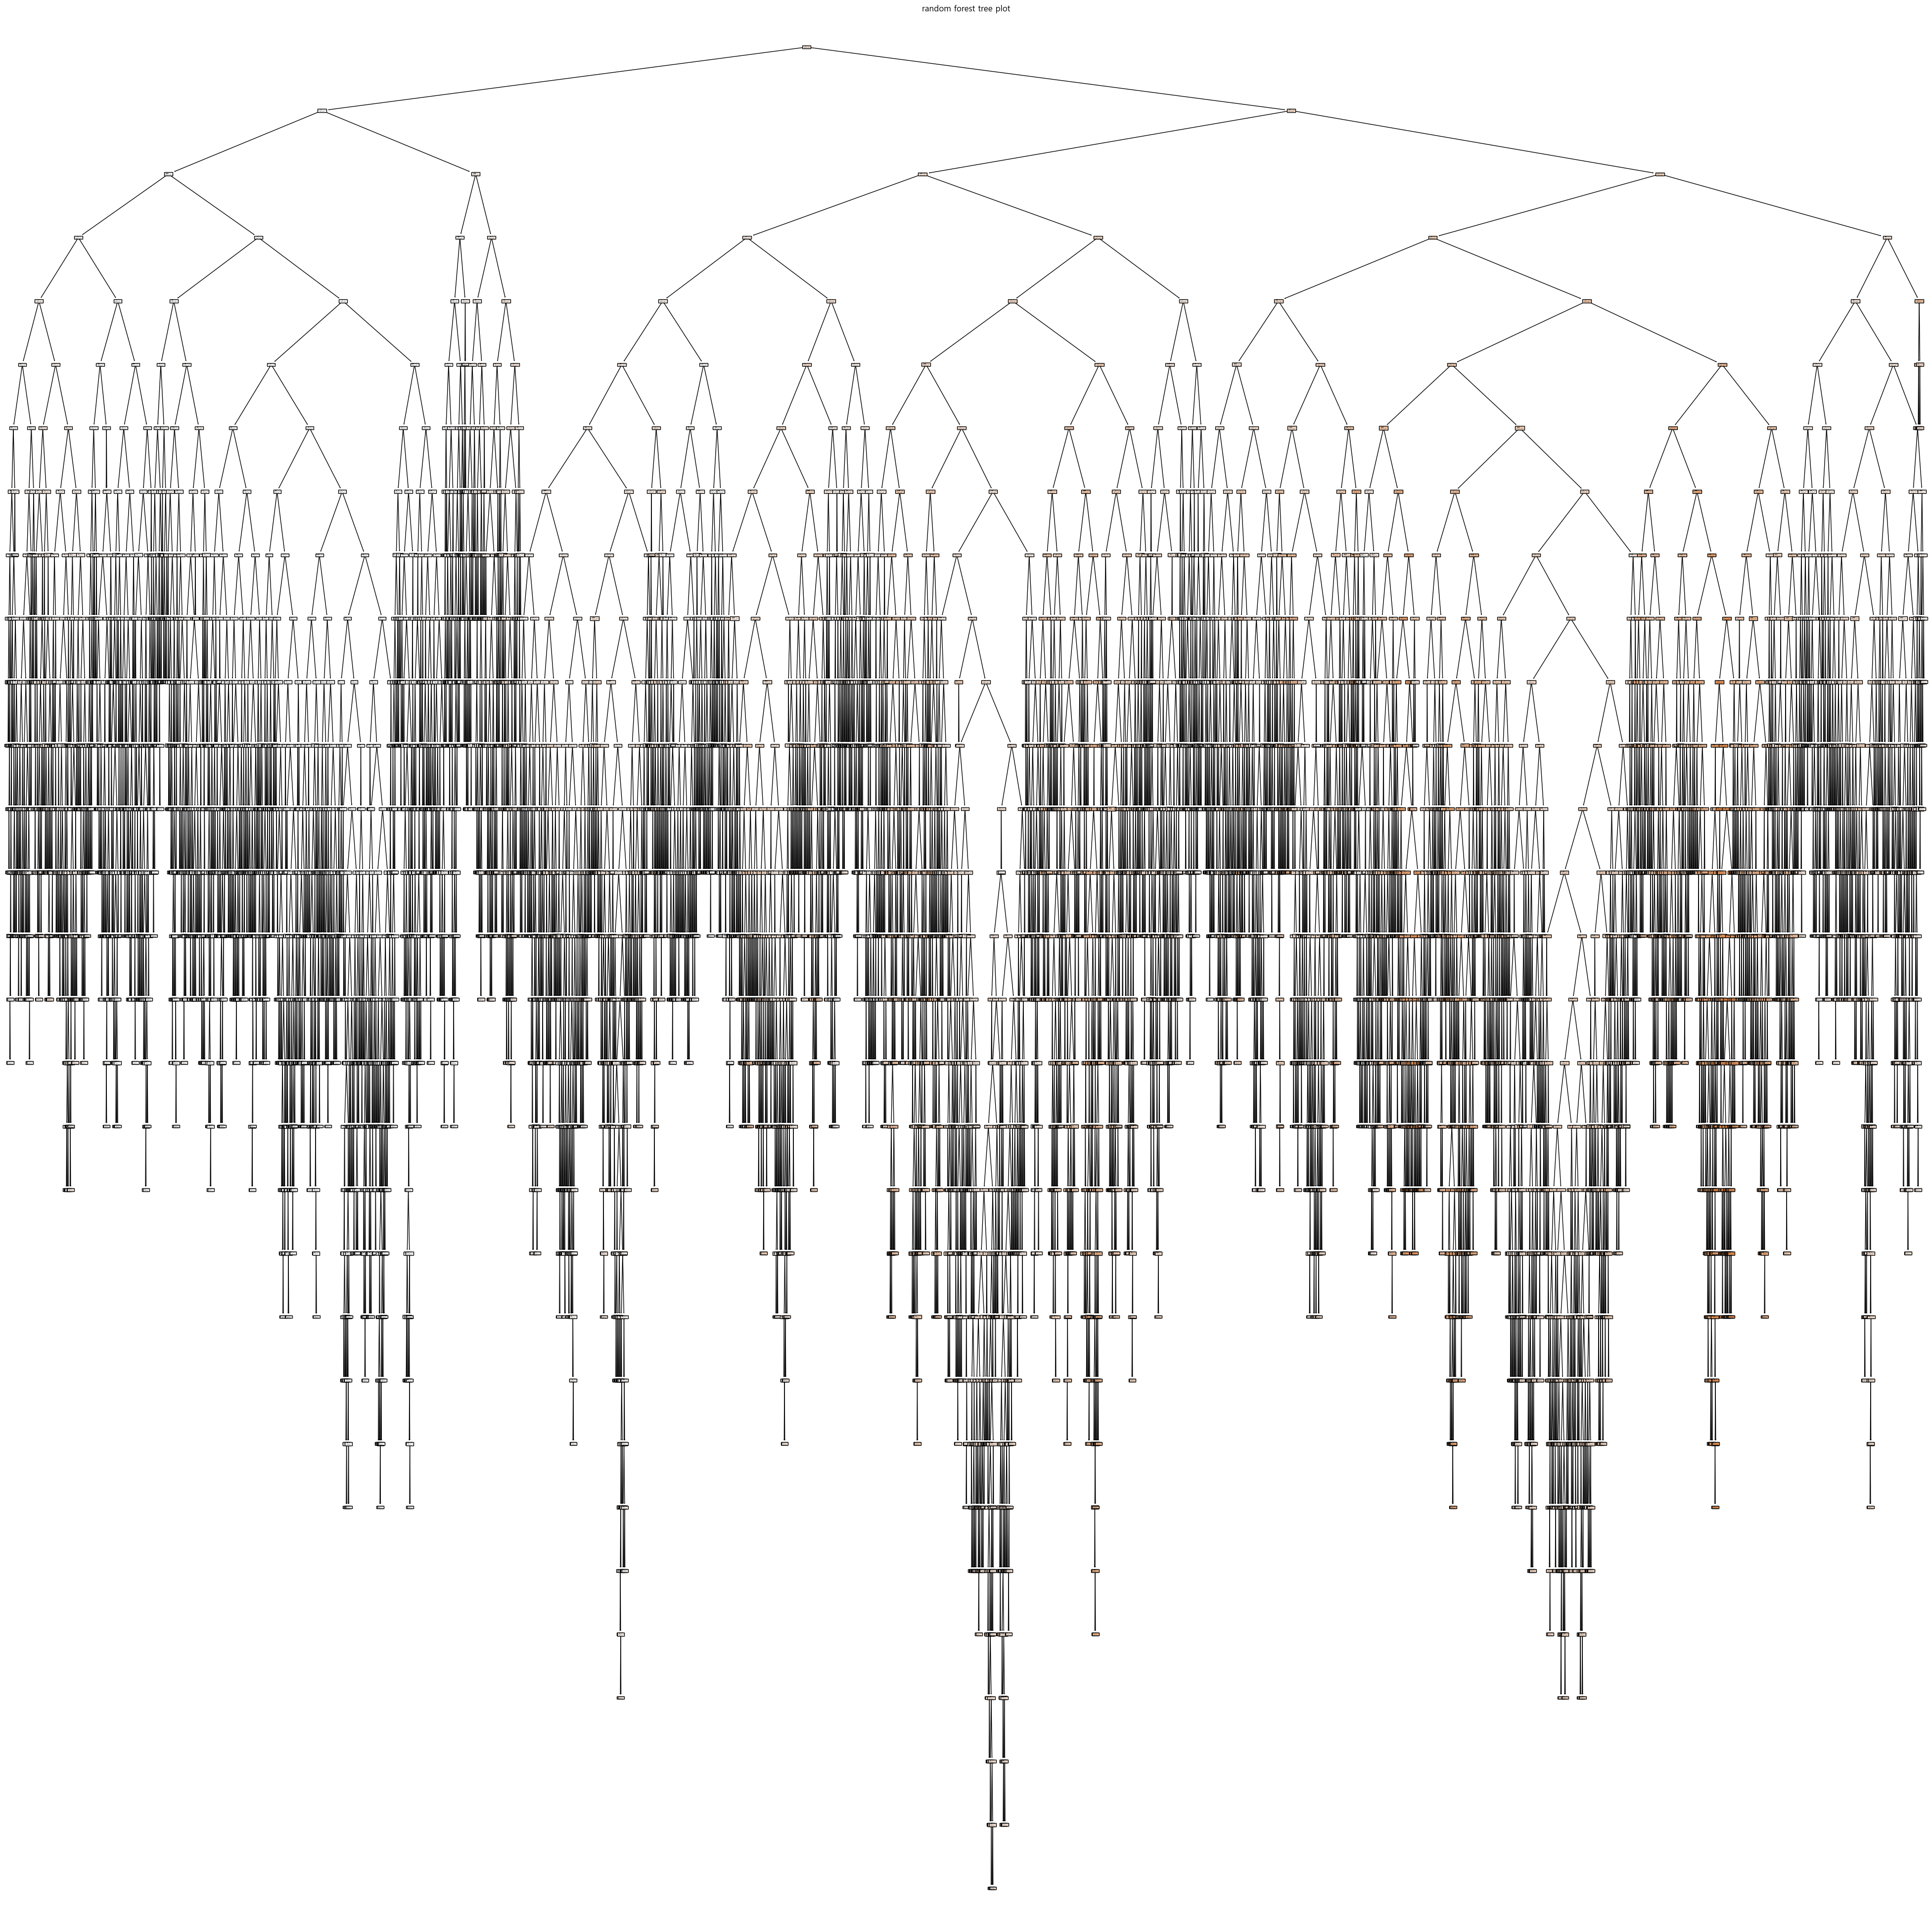

In [46]:
plt.figure(figsize=(50, 50))
plot_tree(rfr.estimators_[0], filled=True, feature_names=X11.columns)
plt.title('random forest tree plot')
plt.show()

In [47]:
rfr_fiv = pd.DataFrame({
    '특성': X11.columns,
    '특성 중요도': rfr_fi
})

rfr_fiv.sort_values('특성 중요도', ascending=False)

특성    특성 중요도
9    시간  0.609550
3    온도  0.094811
6    연도  0.087204
1  주말주중  0.075030
7     월  0.059072
4  상대습도  0.033147
2    날씨  0.015450
8     일  0.013286
5    풍속  0.010022
0  휴일여부  0.002428

- 시간의 특성 중요도가 가장 높게 나타났는데 > 시간 그래프를 봤을 때 7-8시와 17-18시에 가장 높은 대여량을 보이므로 출퇴근 시간에 더 많은 자전거를 비치하는 것이 좋을 것이다?

In [48]:
# 주말주중 별 대여횟수

df_day = df_time.groupby(['주말주중', '시간'])['대여횟수'].sum().reset_index()
df_day.head()

주말주중  시간   대여횟수
0     0   0  13701
1     0   1  10427
2     0   2   7686
3     0   3   3677
4     0   4   1239

In [49]:
# 주말주중 값을 숫자에서 문자열로 변경
df_day.loc[df_day['주말주중'] == 0, '주말주중'] = '주말'
df_day.loc[df_day['주말주중'] == 1, '주말주중'] = '주중'

# 시간을 자주 대여하는 시간대만 출력되도록 변경
df_day = df_day[(df_day['시간'] == 7) | (df_day['시간'] == 8) | (df_day['시간'] == 17) | (df_day['시간'] == 18)]

C:\Users\RMARKET\AppData\Local\Temp\ipykernel_9820\4195845957.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '주말' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_day.loc[df_day['주말주중'] == 0, '주말주중'] = '주말'


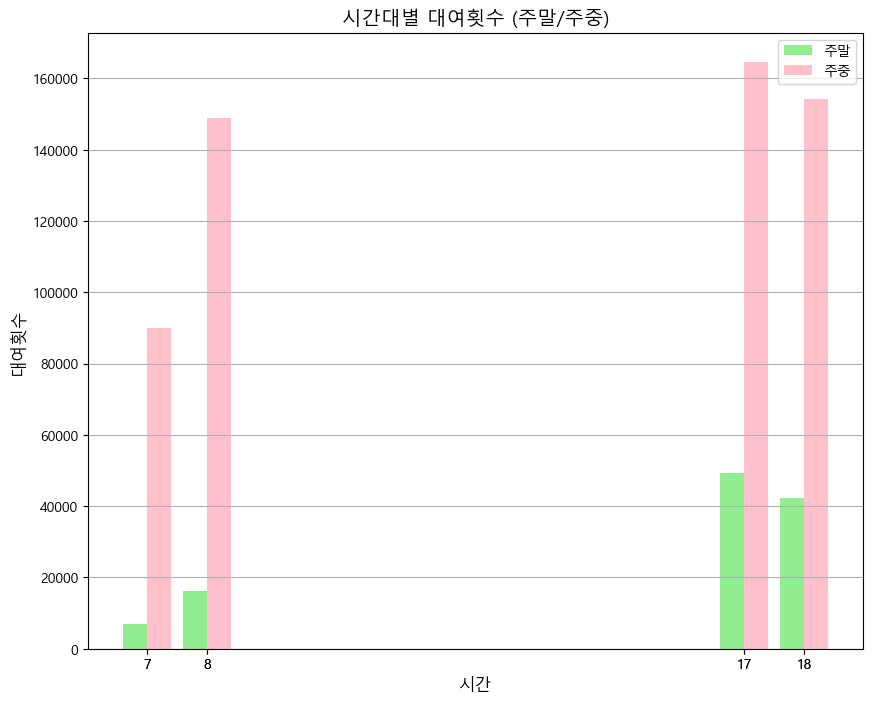

In [50]:
# 주말과 주중 데이터를 각각 필터링
df_weekend = df_day[df_day['주말주중'] == '주말']
df_weekday = df_day[df_day['주말주중'] == '주중']

# 바 그래프 시각화
plt.figure(figsize=(10, 8))

# 주말 데이터는 x 위치를 왼쪽으로 이동
plt.bar(df_weekend['시간'] - 0.2, df_weekend['대여횟수'], width=0.4, label='주말', color='lightgreen')

# 주중 데이터는 x 위치를 오른쪽으로 이동
plt.bar(df_weekday['시간'] + 0.2, df_weekday['대여횟수'], width=0.4, label='주중', color='pink')

# 타이틀, 레이블 설정
plt.title('시간대별 대여횟수 (주말/주중)', fontsize=14)
plt.xlabel('시간', fontsize=12)
plt.ylabel('대여횟수', fontsize=12)

# x축의 ticks (시간대)
plt.xticks(df_day['시간'])

# 범례 추가
plt.legend()

# 그래프 출력
plt.grid(True, axis='y')
plt.show()

주중에 확연하게 많이 빌려가는 것을 볼 수 있으므로, 주중 출퇴근 시간에 많이 배치하는 것이 좋을 것 같다

+) cut

In [51]:
dfrnew = df_time[['시간', '온도', '연도', '주말주중', '월', '상대습도', '일', '풍속', '대여횟수']]

Xrnew = dfrnew.drop('대여횟수', axis=1)
yrnew = dfrnew['대여횟수']

Xrnew_train, Xrnew_test, yrnew_train, yrnew_test = train_test_split(Xrnew, yrnew, test_size=.2, random_state=42)

rfrr = RandomForestRegressor(random_state=42, n_estimators=100)
rfrr.fit(Xrnew_train, yrnew_train)

yrnew_pred = rfrr.predict(Xrnew_test)

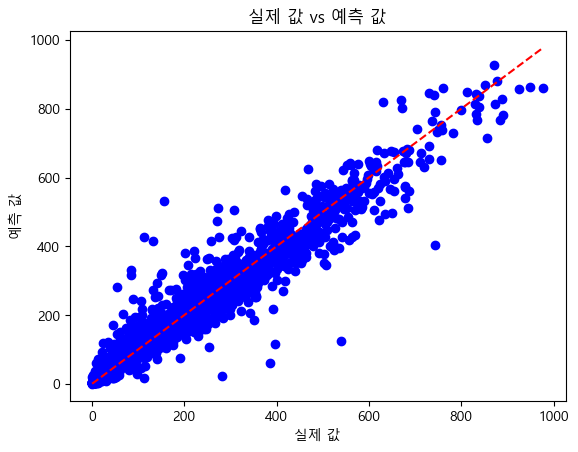

In [52]:
plt.scatter(yrnew_test, yrnew_pred, c='b')
plt.plot([min(yrnew_test), max(yrnew_test)], [min(yrnew_test), max(yrnew_test)], 'r--')  # y = x 직선
plt.xlabel('실제 값')
plt.ylabel('예측 값')
plt.title('실제 값 vs 예측 값')
plt.show()

In [53]:
r2rnew = r2_score(yrnew_test, yrnew_pred)
print(f'결정계수: {r2rnew}')

rmsernew = root_mean_squared_error(yrnew_test, yrnew_pred)
print(f'평균 제곱근 오차: {rmsernew}')  # 3 정도면 나쁘지 않음 

결정계수: 0.9346769232561424
평균 제곱근 오차: 46.43398114087751


'시간', '온도', '연도', '주말주중', '월', '대여횟수'  0.05   
결정계수: 0.8936953442131739  
평균 제곱근 오차: 59.23504837265313  

'시간', '온도', '연도', '주말주중', '월', '상대습도', '대여횟수'  0.03     
결정계수: 0.9310660785313847  
평균 제곱근 오차: 47.700078876664875  

'시간', '온도', '연도', '주말주중', '월', '상대습도', '일', '풍속', '대여횟수'  0.01   
결정계수: 0.9346769232561424  
평균 제곱근 오차: 46.43398114087751  

전체  
r2: 0.9443686857292535, rmse: 42.851128599165534

- 결정계수가 0.99, 1.00 까지 나오는 것은 아니므로 과적합은 아님. 그냥 상관계수, 특성 중요도가 높지 않아도 예측에 사용된다면 성능을 더 높일 수 있을 것.
- 그러나 상관계수, 특성 중요도가 높지 않기 때문에 해당 모델의 예측 값을 무조건적으로 신뢰하여 판단한다면 엉뚱한 결과가 나올 수 있으니 조심 필요

가지치기 & 깊이 제한

In [54]:
# X11, y11 그대로 사용

Xcut_train, Xcut_test, ycut_train, ycut_test = train_test_split(X11, y11, test_size=0.2, random_state=42)

rfrcut = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=22, min_samples_leaf=5)
rfrcut.fit(Xcut_train, ycut_train)

RandomForestRegressor(max_depth=22, min_samples_leaf=5, random_state=42)

In [55]:
# X11, y11 그대로 사용

Xcut_train, Xcut_test, ycut_train, ycut_test = train_test_split(X11, y11, test_size=0.2, random_state=42)

rfrcut = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10, min_samples_leaf=5)
rfrcut.fit(Xcut_train, ycut_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=5, random_state=42)

In [56]:
ycut_pred = rfrcut.predict(Xcut_test)

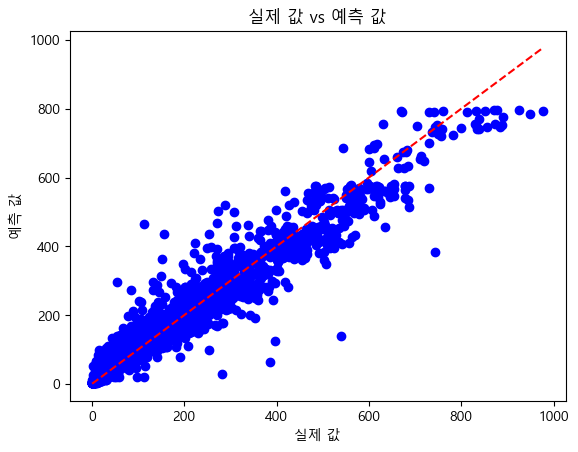

In [57]:
plt.scatter(ycut_test, ycut_pred, c='b')
plt.plot([min(ycut_test), max(ycut_test)], [min(ycut_test), max(ycut_test)], 'r--')  # y = x 직선
plt.xlabel('실제 값')
plt.ylabel('예측 값')
plt.title('실제 값 vs 예측 값')
plt.show()

In [58]:
r2cut = r2_score(ycut_test, ycut_pred)
print(f'결정계수: {r2cut}')

rmsecut = root_mean_squared_error(ycut_test, ycut_pred)
print(f'평균 제곱근 오차: {rmsecut}')  # 3 정도면 나쁘지 않음 

결정계수: 0.9292899252427287
평균 제곱근 오차: 48.31069138943464


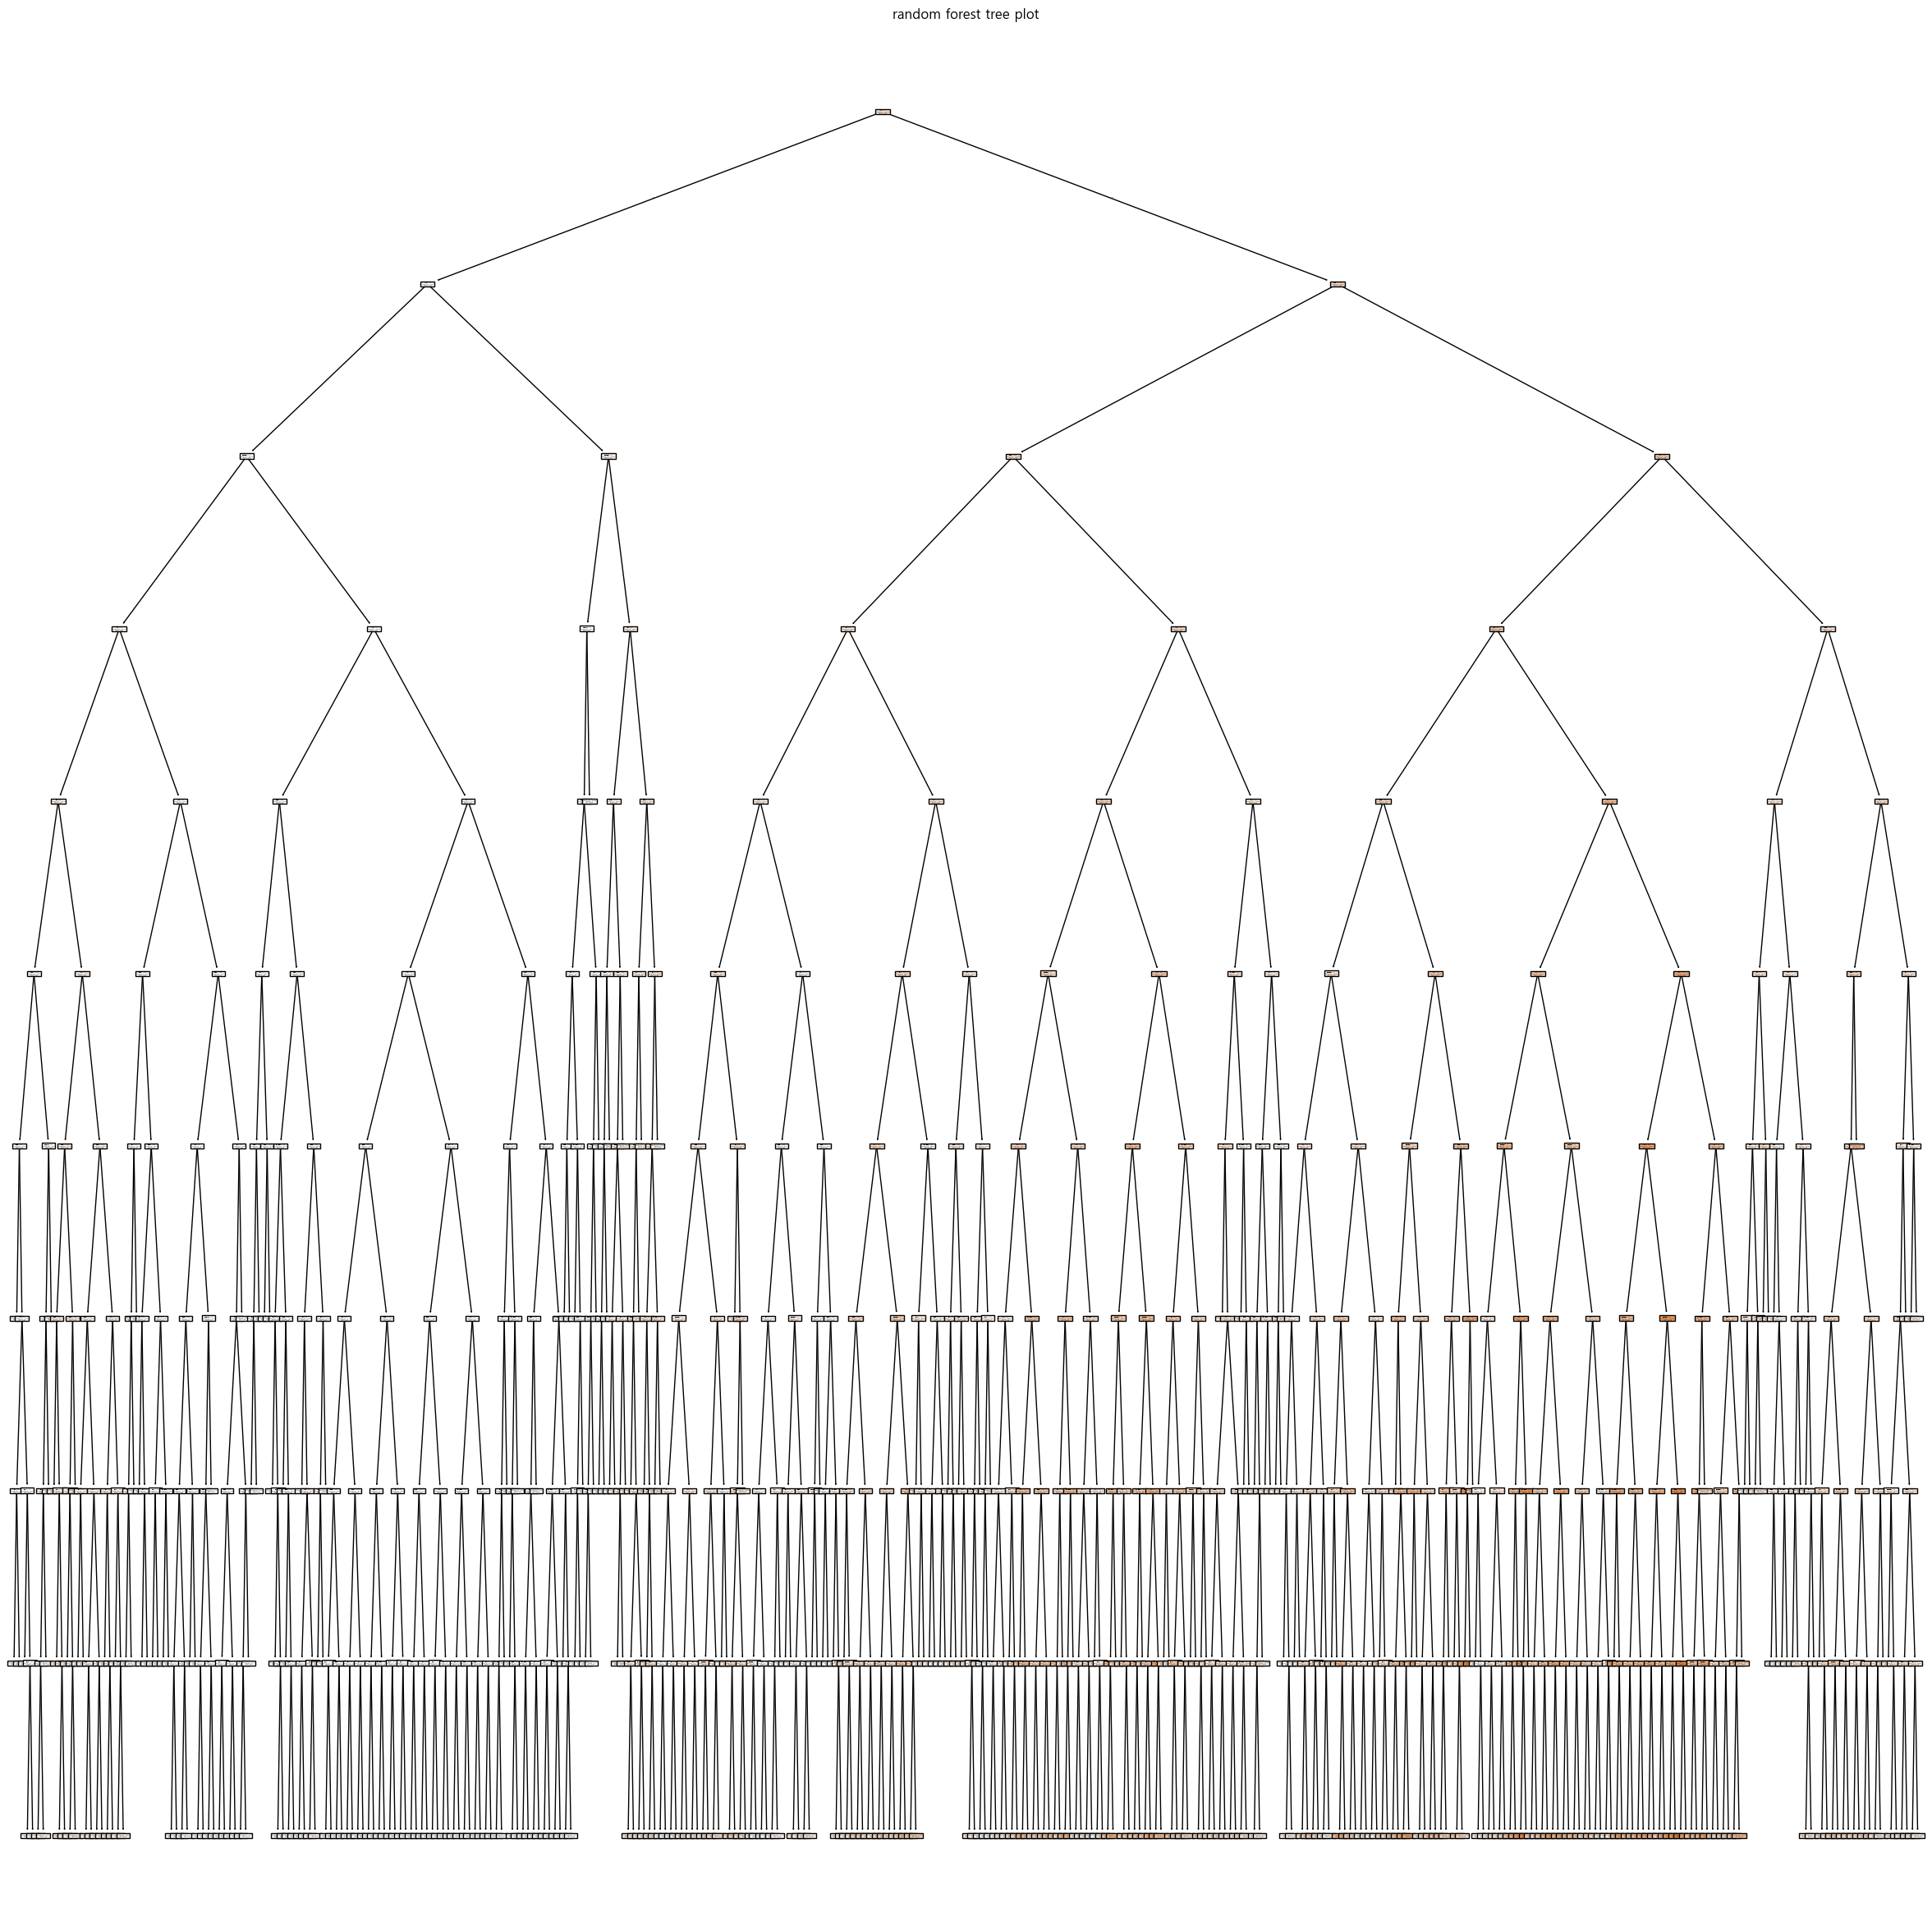

In [59]:
plt.figure(figsize=(30, 30))
plot_tree(rfrcut.estimators_[0], filled=True, feature_names=X11.columns)
plt.title('random forest tree plot')
plt.show()

+) 이상치 제거

In [60]:
basic_columns = X11.columns
basic_columns

Index(['휴일여부', '주말주중', '날씨', '온도', '상대습도', '풍속', '연도', '월', '일', '시간'], dtype='object')

In [61]:
df_out

Xout = df_out[basic_columns]
yout = df_out['대여횟수']

Xout_train, Xout_test, yout_train, yout_test = train_test_split(Xout, yout, test_size=.2, random_state=42)

outrf = RandomForestRegressor(random_state=42)
outrf.fit(Xout_train, yout_train)
youttrain_pred = outrf.predict(Xout_train)
yout_pred = outrf.predict(Xout_test)

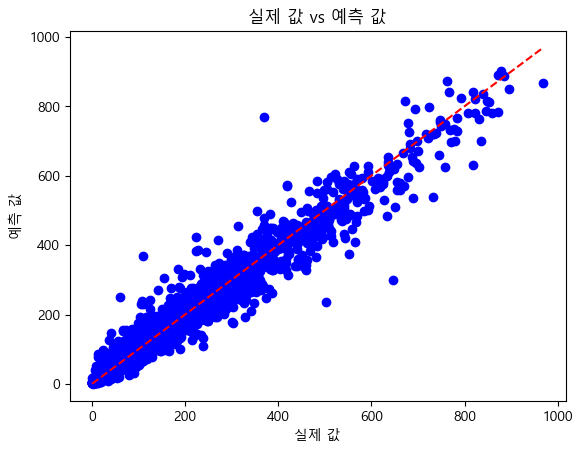

In [62]:
plt.scatter(yout_test, yout_pred, c='b')
plt.plot([min(yout_test), max(yout_test)], [min(yout_test), max(yout_test)], 'r--')  # y = x 직선
plt.xlabel('실제 값')
plt.ylabel('예측 값')
plt.title('실제 값 vs 예측 값')
plt.show()

In [63]:
r2outtrain = r2_score(yout_train, youttrain_pred)
r2out = r2_score(yout_test, yout_pred)
print(f'훈련 결정계수: {r2outtrain}')
print(f'결정계수: {r2out}')

rmseout = root_mean_squared_error(yout_test, yout_pred)
print(f'평균 제곱근 오차: {rmseout}')  # 3 정도면 나쁘지 않음 

훈련 결정계수: 0.9916004267690424
결정계수: 0.9500545206556159
평균 제곱근 오차: 40.497986776910174


대박..이상치제거한게 성능더좋음   
default parameter: n_estimator=100, bootstrap=True, max_depth=None, max_feature='sqrt', min_samples_split=2, min_samples_leaf=1

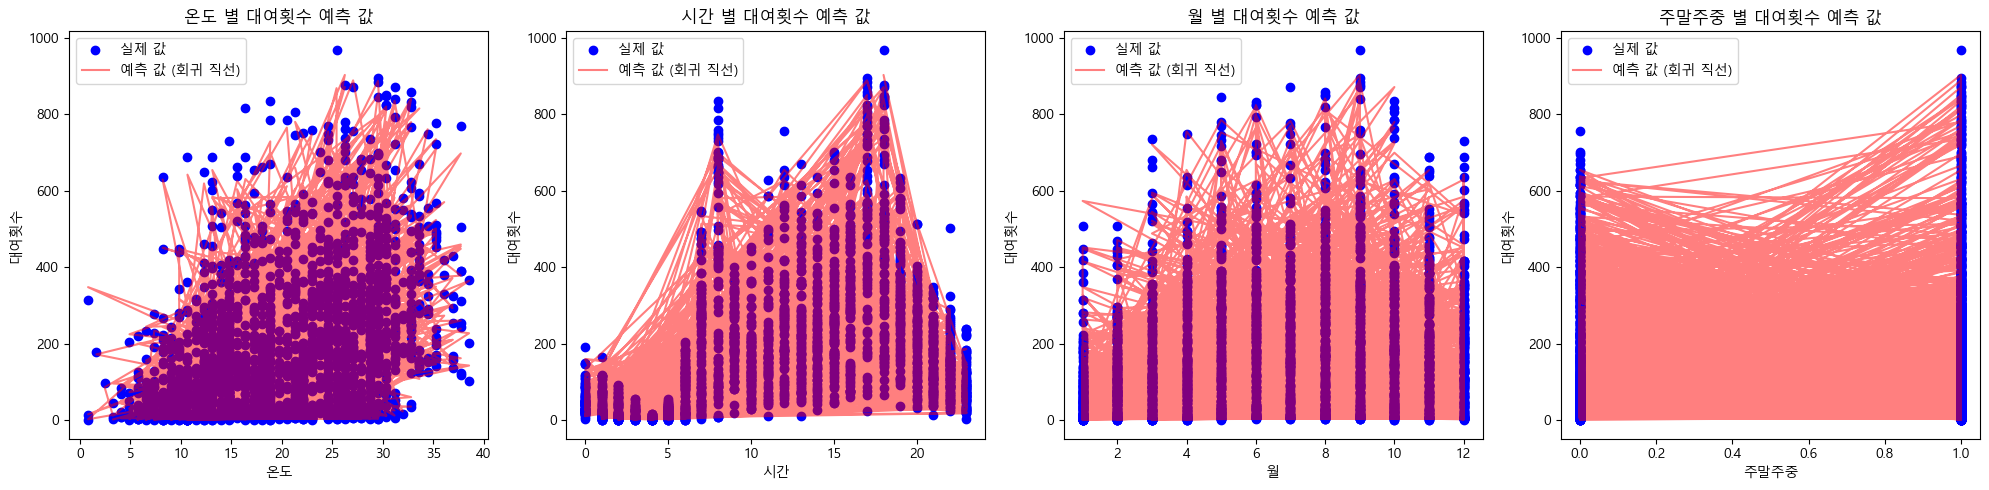

In [104]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.scatter(Xout_test['온도'], yout_test, color='blue', label='실제 값')
plt.plot(Xout_test['온도'], yout_pred, color='red', label='예측 값 (회귀 직선)', alpha=.5)
plt.xlabel('온도')
plt.ylabel('대여횟수')
plt.title('온도 별 대여횟수 예측 값')
plt.legend()

plt.subplot(1, 4, 2)
plt.scatter(Xout_test['시간'], yout_test, color='blue', label='실제 값')
plt.plot(Xout_test['시간'], yout_pred, color='red', label='예측 값 (회귀 직선)', alpha=.5)
plt.xlabel('시간')
plt.ylabel('대여횟수')
plt.title('시간 별 대여횟수 예측 값')
plt.legend()

plt.subplot(1, 4, 3)
plt.scatter(Xout_test['월'], yout_test, color='blue', label='실제 값')
plt.plot(Xout_test['월'], yout_pred, color='red', label='예측 값 (회귀 직선)', alpha=.5)
plt.xlabel('월')
plt.ylabel('대여횟수')
plt.title('월 별 대여횟수 예측 값')
plt.legend()

plt.subplot(1, 4, 4)
plt.scatter(Xout_test['주말주중'], yout_test, color='blue', label='실제 값')
plt.plot(Xout_test['주말주중'], yout_pred, color='red', label='예측 값 (회귀 직선)', alpha=.5)
plt.xlabel('주말주중')
plt.ylabel('대여횟수')
plt.title('주말주중 별 대여횟수 예측 값')
plt.legend()

plt.tight_layout()
plt.show()

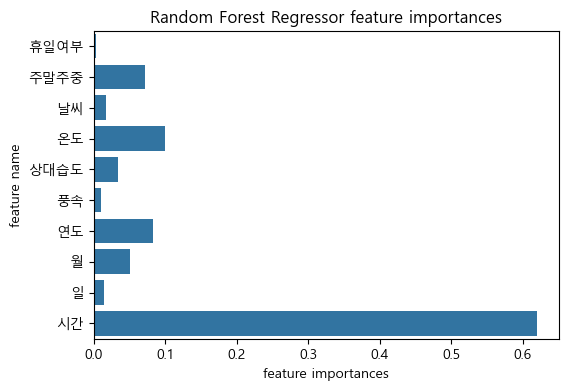

In [96]:
out_fi = outrf.feature_importances_

plt.figure(figsize=(6, 4))
sns.barplot(x=out_fi, y=Xout_test.columns)
plt.title(f'Random Forest Regressor feature importances')
plt.xlabel('feature importances')
plt.ylabel('feature name')
plt.show()

### 5. 분류 분석

- 가설: 주중에 미등록대여가 더 많을 것이다
- 미등록대여와 등록대여를 각각 0, 1로 치환하여 분류 분석

In [64]:
df_time

계절  휴일여부  주말주중  날씨     온도    체감온도  상대습도       풍속  미등록대여횟수  등록대여횟수  \
0       1     0     0   1   9.84  14.395    81   0.0000        3      13   
1       1     0     0   1   9.02  13.635    80   0.0000        8      32   
2       1     0     0   1   9.02  13.635    80   0.0000        5      27   
3       1     0     0   1   9.84  14.395    75   0.0000        3      10   
4       1     0     0   1   9.84  14.395    75   0.0000        0       1   
...    ..   ...   ...  ..    ...     ...   ...      ...      ...     ...   
10881   4     0     1   1  15.58  19.695    50  26.0027        7     329   
10882   4     0     1   1  14.76  17.425    57  15.0013       10     231   
10883   4     0     1   1  13.94  15.910    61  15.0013        4     164   
10884   4     0     1   1  13.94  17.425    61   6.0032       12     117   
10885   4     0     1   1  13.12  16.665    66   8.9981        4      84   

       대여횟수    연도   월   일  시간  
0        16  2011   1   1   0  
1        40  2011   1   1   1  
2        32  2011   1   1   2  
3        13  2011   1   1   3  
4         1  2011   1   1   4  
...     ...   ...  ..  ..  ..  
10881   336  2012  12  19  19  
10882   241  2012  12  19  20  
10883   168  2012  12  19  21  
10884   129  2012  12  19  22  
10885    88  2012  12  19  23  

[10886 rows x 15 columns]

In [65]:
df_time['등록여부'] = (df_time['미등록대여횟수'] < df_time['등록대여횟수'])

df_time.head()

계절  휴일여부  주말주중  날씨    온도    체감온도  상대습도   풍속  미등록대여횟수  등록대여횟수  대여횟수    연도  \
0   1     0     0   1  9.84  14.395    81  0.0        3      13    16  2011   
1   1     0     0   1  9.02  13.635    80  0.0        8      32    40  2011   
2   1     0     0   1  9.02  13.635    80  0.0        5      27    32  2011   
3   1     0     0   1  9.84  14.395    75  0.0        3      10    13  2011   
4   1     0     0   1  9.84  14.395    75  0.0        0       1     1  2011   

   월  일  시간  등록여부  
0  1  1   0  True  
1  1  1   1  True  
2  1  1   2  True  
3  1  1   3  True  
4  1  1   4  True

In [66]:
df_reg = df_time.drop(['미등록대여횟수', '등록대여횟수', '대여횟수'], axis=1)

df_reg.head()

계절  휴일여부  주말주중  날씨    온도    체감온도  상대습도   풍속    연도  월  일  시간  등록여부
0   1     0     0   1  9.84  14.395    81  0.0  2011  1  1   0  True
1   1     0     0   1  9.02  13.635    80  0.0  2011  1  1   1  True
2   1     0     0   1  9.02  13.635    80  0.0  2011  1  1   2  True
3   1     0     0   1  9.84  14.395    75  0.0  2011  1  1   3  True
4   1     0     0   1  9.84  14.395    75  0.0  2011  1  1   4  True

In [67]:
Xc = df_reg.drop('등록여부', axis=1)
yc = df_reg['등록여부']

In [68]:
scale_features = ['온도', '체감온도', '상대습도', '풍속']

In [69]:
# 특성들이 서로 다른 범위를 가지고 있기 때문에 정규화를 진행

std = StandardScaler()

df_std = Xc.copy()
df_std[scale_features] = std.fit_transform(df_reg[scale_features])

df_std.head()

계절  휴일여부  주말주중  날씨        온도      체감온도      상대습도        풍속    연도  월  일  시간
0   1     0     0   1 -1.333661 -1.092737  0.993213 -1.567754  2011  1  1   0
1   1     0     0   1 -1.438907 -1.182421  0.941249 -1.567754  2011  1  1   1
2   1     0     0   1 -1.438907 -1.182421  0.941249 -1.567754  2011  1  1   2
3   1     0     0   1 -1.333661 -1.092737  0.681430 -1.567754  2011  1  1   3
4   1     0     0   1 -1.333661 -1.092737  0.681430 -1.567754  2011  1  1   4

In [70]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=.2, random_state=42)

In [71]:
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Ada Boost': AdaBoostClassifier(random_state=42, algorithm='SAMME'),
    'Voting': VotingClassifier(
        estimators=[
            ('logistic', LogisticRegression(random_state=42, max_iter=5000)),
            ('dt', DecisionTreeClassifier(random_state=42))
        ],
        voting='soft'
    )
}

---------------------------Random Forest---------------------------
Random Forest 정확도: 0.976, 정밀도: 0.979, 재현율: 0.997, f1: 0.988


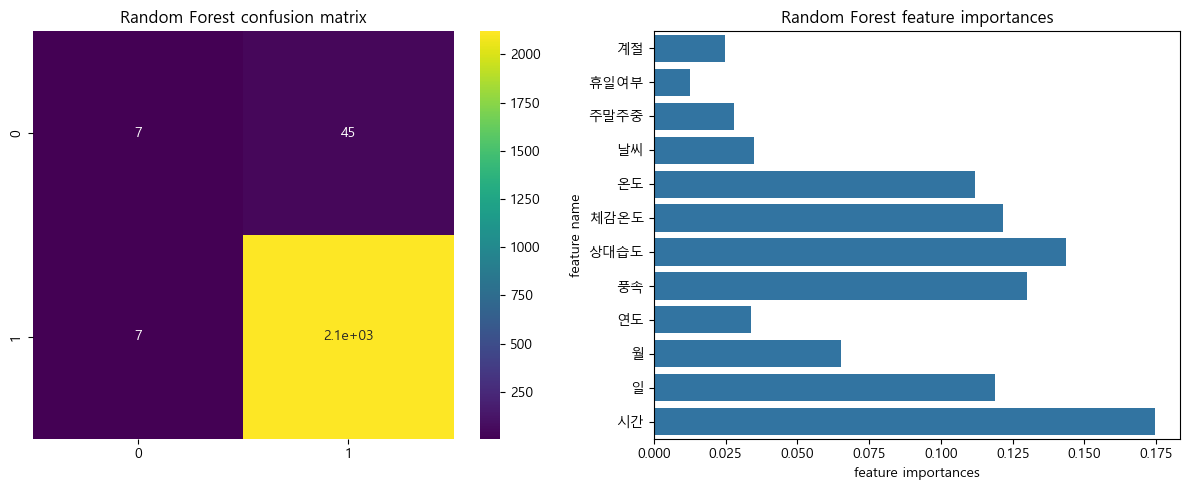

---------------------------Ada Boost---------------------------
Ada Boost 정확도: 0.976, 정밀도: 0.976, 재현율: 1.000, f1: 0.988


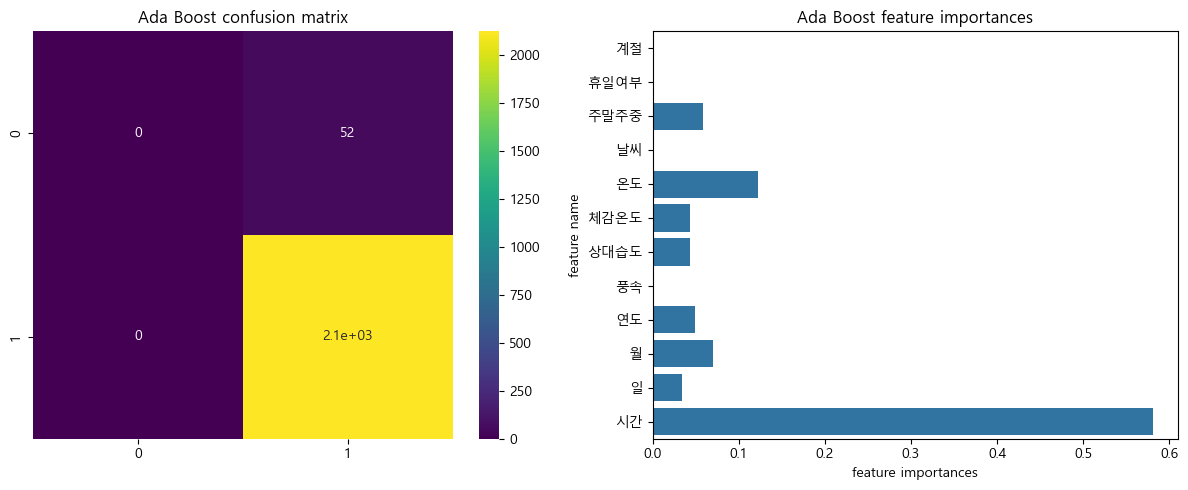

---------------------------Voting---------------------------
Voting 정확도: 0.957, 정밀도: 0.979, 재현율: 0.976, f1: 0.978


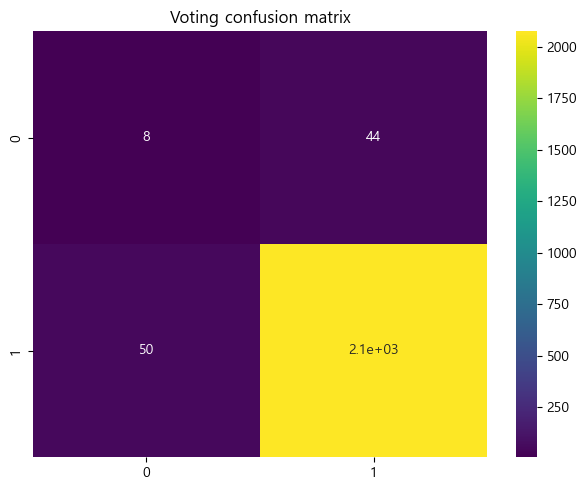

In [72]:
for name, model in models.items():
    model.fit(Xc_train, yc_train)
    yc_pred = model.predict(Xc_test)
    print(f'---------------------------{name}---------------------------')
    print(f'{name} 정확도: {accuracy_score(yc_test, yc_pred):.3f}, 정밀도: {precision_score(yc_test, yc_pred):.3f}, 재현율: {recall_score(yc_test, yc_pred):.3f}, f1: {f1_score(yc_test, yc_pred):.3f}')
    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.heatmap(confusion_matrix(yc_test, yc_pred), cmap='viridis', annot=True)
    plt.title(f'{name} confusion matrix')

    if name != 'Voting':
        cfeatures = Xc.columns
        feature_importances = model.feature_importances_

        plt.subplot(1, 2, 2)
        sns.barplot(x=feature_importances, y=cfeatures)
        plt.title(f'{name} feature importances')
        plt.xlabel('feature importances')
        plt.ylabel('feature name')
    
    plt.tight_layout()
    plt.show()

- 정확도, 정밀도, 재현율, F1을 모두 고려했을 때 Random Forest 분류기가 가장 성능이 좋다
- 등록 여부에 가장 많은 영향을 끼치고 있는 변수 Top 3는 시간, 상대습도, 풍속

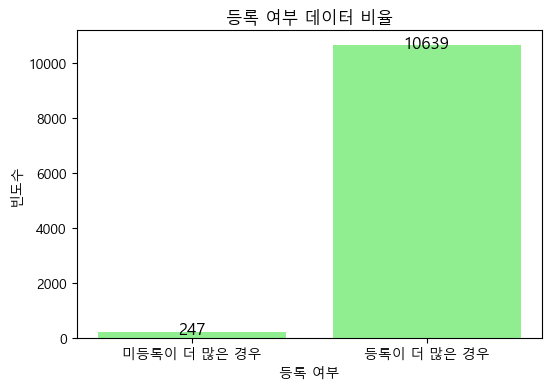

In [ ]:
count = df_reg['등록여부'].value_counts()

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(count.index, count.values, color='lightgreen')
ax.set_xticks([0, 1])
ax.set_xticklabels(['미등록이 더 많은 경우', '등록이 더 많은 경우'])
ax.bar_label(bars, padding=-5, fontsize=12)
ax.set_title('등록 여부 데이터 비율')
ax.set_xlabel('등록 여부')
ax.set_ylabel('빈도수')

plt.show()

In [73]:
# best parameter 찾기

rf = RandomForestClassifier(random_state=42)

grid_prams = {
    'n_estimators': [100, 150],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [3, 5],
    'min_samples_leaf': [5, 10]
}

grid_search = GridSearchCV(estimator=rf, param_grid=grid_prams, cv=5, scoring='accuracy')
grid_search.fit(Xc_train, yc_train)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_:.3f}')

best_model = grid_search.best_estimator_
yr_pred = best_model.predict(Xc_test)

print(f'정확도: {accuracy_score(yc_test, yr_pred):.3f}, 정밀도: {precision_score(yc_test, yr_pred):.3f}, 재현율: {recall_score(yc_test, yr_pred):.3f}, f1: {f1_score(yc_test, yr_pred):.3f}')


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 100}
Best Score: 0.978
정확도: 0.976, 정밀도: 0.976, 재현율: 1.000, f1: 0.988


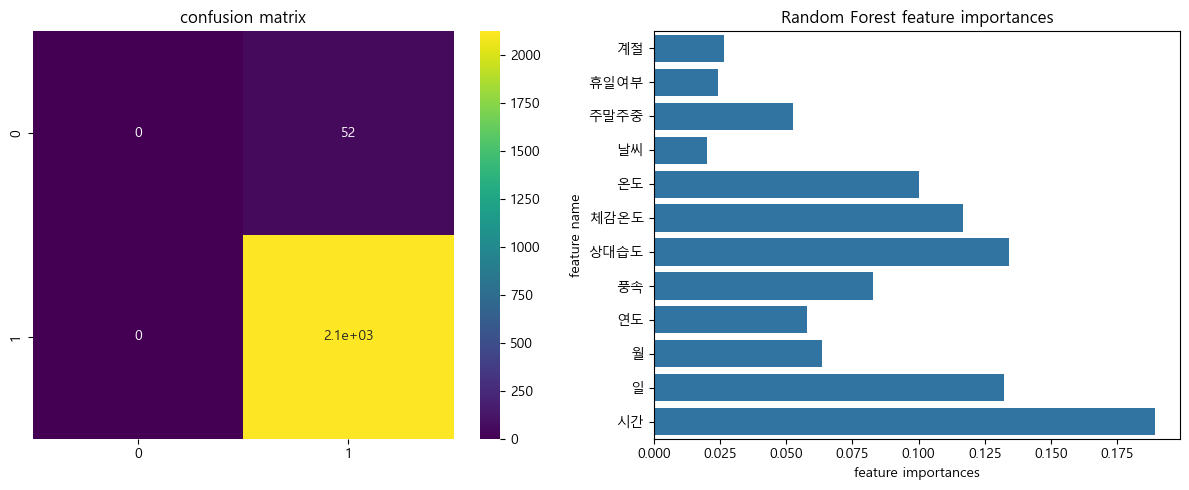

In [74]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(yc_test, yr_pred), cmap='viridis', annot=True)
plt.title(f'confusion matrix')

rfeatures = Xc.columns
rfeature_importances = best_model.feature_importances_

plt.subplot(1, 2, 2)
sns.barplot(x=rfeature_importances, y=rfeatures)
plt.title(f'Random Forest feature importances')
plt.xlabel('feature importances')
plt.ylabel('feature name')
    
plt.tight_layout()
plt.show()

In [75]:
fi = pd.DataFrame({
    '특성': rfeatures,
    '특성 중요도': rfeature_importances
})

fi.sort_values('특성 중요도', ascending=False)

특성    특성 중요도
11    시간  0.189287
6   상대습도  0.134180
10     일  0.132115
5   체감온도  0.116732
4     온도  0.100017
7     풍속  0.082858
9      월  0.063486
8     연도  0.057893
2   주말주중  0.052563
0     계절  0.026612
1   휴일여부  0.024125
3     날씨  0.020132

특성 중요도가 0.05 이상인 것들만으로 다시

In [76]:
refeatures = fi[fi['특성 중요도'] >= 0.05]['특성'].tolist()
refeatures

['주말주중', '온도', '체감온도', '상대습도', '풍속', '연도', '월', '일', '시간']

In [77]:
df_re = df_std[refeatures]

In [78]:
Xre = df_re
yre = df_time['등록여부']

Xre_train, Xre_test, yre_train, yre_test = train_test_split(Xre, yre, test_size=.2, random_state=42)

In [79]:
# best parameter 찾기

rfre = RandomForestClassifier(random_state=42)

grid_prams = {
    'n_estimators': [100, 150],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [3, 5],
    'min_samples_leaf': [5, 10]
}

grid_searchre = GridSearchCV(estimator=rfre, param_grid=grid_prams, cv=5, scoring='accuracy')
grid_searchre.fit(Xre_train, yre_train)

print(f'Best Parameters: {grid_searchre.best_params_}')
print(f'Best Score: {grid_searchre.best_score_:.3f}')

best_modelre = grid_searchre.best_estimator_
yre_pred = best_modelre.predict(Xre_test)

print(f'정확도: {accuracy_score(yre_test, yre_pred):.3f}, 정밀도: {precision_score(yre_test, yre_pred):.3f}, 재현율: {recall_score(yre_test, yre_pred):.3f}, f1: {f1_score(yre_test, yre_pred):.3f}')


Best Parameters: {'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 150}
Best Score: 0.978
정확도: 0.976, 정밀도: 0.976, 재현율: 1.000, f1: 0.988


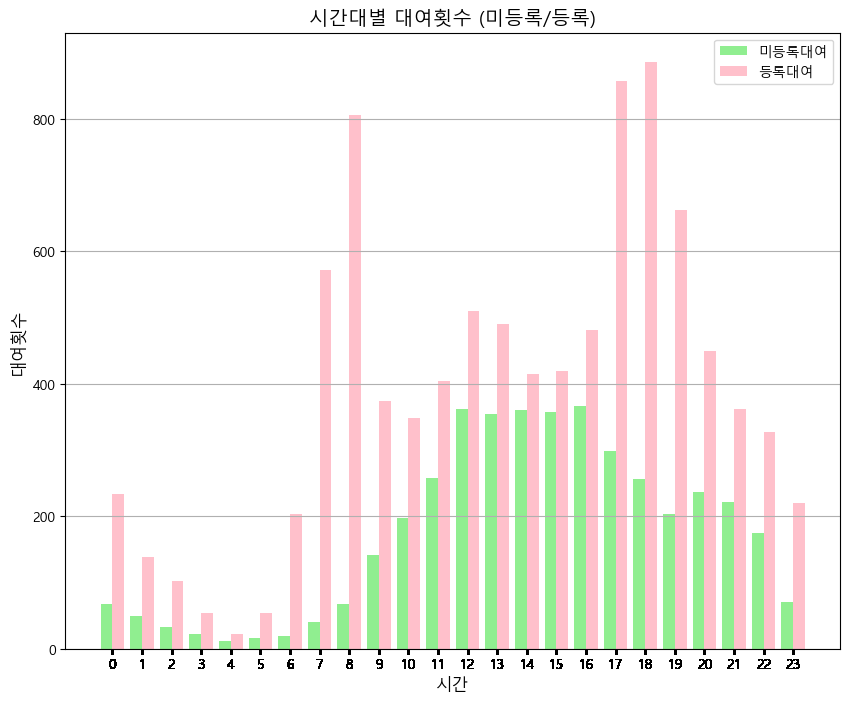

In [ ]:
# 바 그래프 시각화
plt.figure(figsize=(10, 8))

plt.bar(df_time['시간'] - 0.2, df_time['미등록대여횟수'], width=0.4, label='미등록대여', color='lightgreen')
plt.bar(df_time['시간'] + 0.2, df_time['등록대여횟수'], width=0.4, label='등록대여', color='pink')

# 타이틀, 레이블 설정
plt.title('시간대별 대여횟수 (미등록/등록)', fontsize=14)
plt.xlabel('시간', fontsize=12)
plt.ylabel('대여횟수', fontsize=12)

# x축의 ticks (시간대)
plt.xticks(df_time['시간'])

# 범례 추가
plt.legend()

# 그래프 출력
plt.grid(True, axis='y')
plt.show()

- 데이터의 불균형, 등록대여 개수가 미등록대여 개수보다 훨씬 많았다.
- 예측 시, parameter를 설정하면 정확도 등 평가 기준 값들은 높았으나 모델이 전체 값을 True로 예측했으며 분별력이 없다고 판단됐다.
- parameter를 사용하지 않더라도 False라고 예측했을 때 예측이 맞은 경우는 7/52(0.135)정도밖에 되지 않는다.
- 따라서 이 종속변수를 꼭 예측한다면 Random Forest Classifier를 하이퍼파라미터 지정 없이 하는 것이 제일 성능이 좋지만, 의미는 없다고 생각한다.

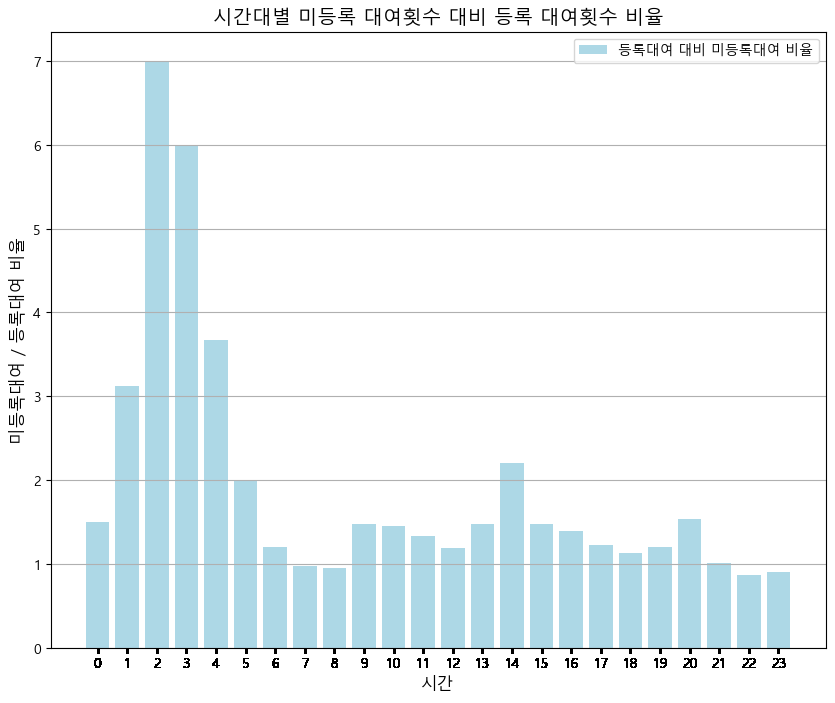

In [ ]:
# 비율 계산: 등록 대여횟수 / 미등록 대여횟수
df_time['비율'] = df_time['미등록대여횟수'] / df_time['등록대여횟수']

# 비율 그래프 시각화
plt.figure(figsize=(10, 8))

# 비율을 바 그래프로 그리기
plt.bar(df_time['시간'], df_time['비율'], color='lightblue', label='등록대여 대비 미등록대여 비율')

# 타이틀, 레이블 설정
plt.title('시간대별 미등록 대여횟수 대비 등록 대여횟수 비율', fontsize=14)
plt.xlabel('시간', fontsize=12)
plt.ylabel('미등록대여 / 미등록대여 비율', fontsize=12)

# x축의 ticks (시간대)
plt.xticks(df_time['시간'])

# 그래프 출력
plt.grid(True, axis='y')
plt.legend()
plt.show()

In [122]:
df_time

계절  휴일여부  주말주중  날씨     온도    체감온도  상대습도       풍속  미등록대여횟수  등록대여횟수  \
0       1     0     0   1   9.84  14.395    81   0.0000        3      13   
1       1     0     0   1   9.02  13.635    80   0.0000        8      32   
2       1     0     0   1   9.02  13.635    80   0.0000        5      27   
3       1     0     0   1   9.84  14.395    75   0.0000        3      10   
4       1     0     0   1   9.84  14.395    75   0.0000        0       1   
...    ..   ...   ...  ..    ...     ...   ...      ...      ...     ...   
10881   4     0     1   1  15.58  19.695    50  26.0027        7     329   
10882   4     0     1   1  14.76  17.425    57  15.0013       10     231   
10883   4     0     1   1  13.94  15.910    61  15.0013        4     164   
10884   4     0     1   1  13.94  17.425    61   6.0032       12     117   
10885   4     0     1   1  13.12  16.665    66   8.9981        4      84   

       대여횟수    연도   월   일  시간  등록여부        비율  
0        16  2011   1   1   0  True  0.230769  
1        40  2011   1   1   1  True  0.250000  
2        32  2011   1   1   2  True  0.185185  
3        13  2011   1   1   3  True  0.300000  
4         1  2011   1   1   4  True  0.000000  
...     ...   ...  ..  ..  ..   ...       ...  
10881   336  2012  12  19  19  True  0.021277  
10882   241  2012  12  19  20  True  0.043290  
10883   168  2012  12  19  21  True  0.024390  
10884   129  2012  12  19  22  True  0.102564  
10885    88  2012  12  19  23  True  0.047619  

[10886 rows x 17 columns]

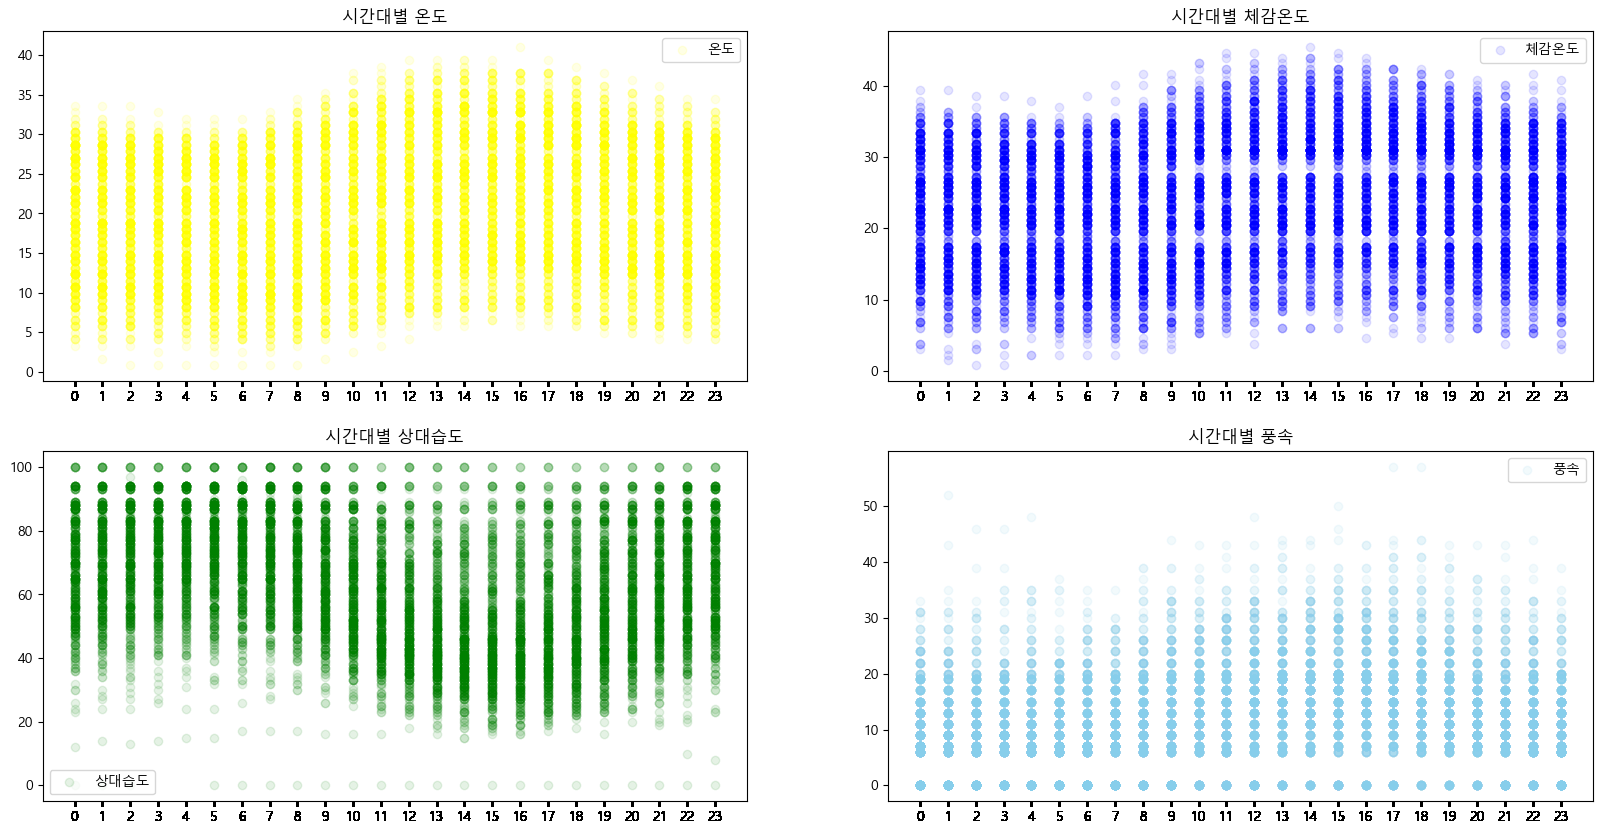

In [140]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.scatter(df_time['시간'], df_time['온도'], c='yellow', alpha=.1, label='온도')
plt.title('시간대별 온도')
plt.xticks(df_time['시간'])
plt.legend()

plt.subplot(2, 2, 2)
plt.scatter(df_time['시간'], df_time['체감온도'], c='blue', alpha=.1, label='체감온도')
plt.title('시간대별 체감온도')
plt.xticks(df_time['시간'])
plt.legend()

plt.subplot(2, 2, 3)
plt.scatter(df_time['시간'], df_time['상대습도'], c='green', alpha=.1, label='상대습도')
plt.title('시간대별 상대습도')
plt.xticks(df_time['시간'])
plt.legend()

plt.subplot(2, 2, 4)
plt.scatter(df_time['시간'], df_time['풍속'], c='skyblue', alpha=.1, label='풍속')
plt.title('시간대별 풍속')
plt.xticks(df_time['시간'])
plt.legend()


plt.show()